In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [3]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [4]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [5]:
Simbad.add_votable_fields("otype","parallax")

In [6]:
tbl = pd.read_csv('gfcat_visit_table_positions.csv',index_col=None)

In [7]:
# Crossmatch to SIMBAD
for i in tqdm.tqdm(np.arange(len(tbl[:]))):
    ra,dec=tbl.iloc[i][['ra','dec']].values
    r = Simbad.query_region(coord.SkyCoord(ra,dec,
                            unit=(u.deg, u.deg)),#, frame='icrs'),
                            radius=35/60/60*u.deg)
    try:
        c = coord.SkyCoord(r['RA'],r['DEC'],unit=(u.hourangle, u.deg))
        d = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)
        tbl.loc[i,'simbad_n_match'] = sum(d<17.5/60/60)
        # preserve the order of otype when unique-ifying them
        otype,ix=np.unique(np.array(r['OTYPE'],dtype='str'),return_index=True)
        tbl.loc[i,'simbad_otype'] = ', '.join(np.array(r['OTYPE'],dtype='str')[ix].tolist())
        tbl.loc[i,'simbad_main_id'] = r['MAIN_ID'][0]
        tbl.loc[i,'simbad_distance'] = 1000/r['PLX_VALUE'][0]
        c = coord.SkyCoord(f"{r['RA'][0]} {r['DEC'][0]}", unit=(u.hourangle, u.deg))
        tbl.loc[i,'simbad_match_offset'] = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)[0]*60*60
    except TypeError:
        continue

tbl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2353/2353 [00:23<00:00, 100.62it/s]


,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_match_offset
0,26808,20726808.0,185.750875,29.544538,T,1.0,Star,BD+30 2263,688.231246,2.523201
1,21378,39121378.0,204.877337,30.654018,U,1.0,WhiteDwarf_Candidate,SDSS J133930.42+303915.8,207.913175,2.405300
2,26045,41026045.0,149.468637,2.338955,U,14.0,"AGN, Galaxy, GroupG, QSO",[VV2006] J095752.3+022021,17667.844523,2.511708
3,23102,42723102.0,257.253864,58.873073,F,NaN,NaN,NaN,NaN,NaN
4,17070,44617070.0,247.108147,40.861124,F,2.0,"EmissionG, GroupG, Star",[KB98] Obj J162826+405143,54.691431,2.408693
...,...,...,...,...,...,...,...,...,...,...
2348,46807,NaN,183.176317,-26.926904,U,1.0,HighPM*,2MASS J12124204-2655328,43.672699,5.210580
2349,46818,NaN,184.069175,-30.364380,U,1.0,Star,UCAC2 19153424,1367.240908,8.818930
2350,46828,NaN,183.710681,-32.431776,F,NaN,NaN,NaN,NaN,NaN
2351,46828,NaN,183.706376,-32.431746,F,NaN,NaN,NaN,NaN,NaN


In [8]:
fn = '/Users/cm/github/gphoton_working/gPhoton/aspect/aspect.parquet'
for i in tqdm.tqdm(np.arange(len(tbl))[:]):
    eclipse = int(tbl.iloc[i]['eclipse'])
    aspect = pq.read_table(fn,filters=[('eclipse','=',eclipse)]).to_pandas()
    obstart = aspect.loc[aspect['flags']%2==0]['time'].min()
    #obsend = aspect.loc[aspect['flags']%2==0]['time'].max()
    #obsdur = obsend-obstart
    GPSSECS = 315532800 + 432000
    t = obstart + GPSSECS
    dt = datetime.datetime.fromtimestamp(t)
    tbl.loc[i,'obstart']=int(obstart)
    tbl.loc[i,'datetime_iso']=dt.isoformat().split('.')[0]
    tbl.loc[i,'datetime_decimal']=Time(dt,format='datetime').decimalyear
    ra,dec = tbl.iloc[i]['ra'],tbl.iloc[i]['dec']
    decimal_year = tbl.iloc[i]['datetime_decimal']
    #coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    width = u.Quantity(0.05, u.deg)
    height = u.Quantity(0.05, u.deg)
    # the Gaia search API likes to timeout badly, randomly, often... so try to mitigate
    query_success=0
    while query_success==0:
        #print(ra,dec)
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            query_success=1
        except TimeoutError:
            pass
    # compute the offset in years between the gaia epoch (2016) and the galex epoch
    year_offset = np.array(r['ref_epoch'])-decimal_year
    # the sky positions of gaia sources in degrees
    ra_gaia,dec_gaia = np.array(r['ra']),np.array(r['dec'])
    # the proper motions of gaia sources, converted from mas to deg per year
    ra_gaia_pm,dec_gaia_pm = np.array(r['pmra'])/60/60/1000,np.array(r['pmdec'])/60/60/1000
    # \"rewind\" the gaia sky positions by the proper motion rate by the difference in epochs
    ra_old = ra_gaia-ra_gaia_pm*year_offset
    dec_old = dec_gaia-dec_gaia_pm*year_offset

    # ignore nan values (usually because missing pm data)
    ix_finite = np.where(np.isfinite(ra_old) & np.isfinite(dec_old))
    d = angularSeparation(ra,dec,ra_old[ix_finite],dec_old[ix_finite])
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        continue
    ix = ix_finite[0][ix_match]
    tbl.loc[i,'gaia_source_id']=r[ix]['source_id']
    #tbl.loc[i,'gaia_distance_uncorrected']=1000/r[ix]['parallax'][0]
    tbl.loc[i,'gaia_distance']=1000/r[ix]['parallax']
    tbl.loc[i,'gaia_distance_err']=1000/r[ix]['parallax_error']
    tbl.loc[i,'gaia_parallax_over_err'] = r[ix]['parallax_over_error']
    tbl.loc[i,'pmra']=r[ix]['pmra']
    tbl.loc[i,'pmdec']=r[ix]['pmdec']
    tbl.loc[i,'gaia_ra']=r[ix]['ra']
    tbl.loc[i,'gaia_dec']=r[ix]['dec']
    tbl.loc[i,'gaia_match_offset']=angularSeparation(ra,dec,r[ix]['ra'],r[ix]['dec'])*60*60
    #tbl.loc[i,'gaia_match_offset_uncorrected']=angularSeparation(ra,dec,
    #                                                             r[ix_goodsnr]['ra'][0],
    #                                                             r[ix_goodsnr]['dec'][0])*60*60
    tbl.loc[i,'gaia_n_match']=sum(d<17.5/60/60)
    #tbl.loc[i,'high_pm']='Y' if ix!=0 else 'N' # the best match changed after 'rewinding'
    #time.sleep(1) # to prevent what I interpreted to be timeouts due to rate limiting

  0%|                                                                                                                                   | 1/2353 [00:03<2:10:03,  3.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|                                                                                                                                   | 2/2353 [00:05<1:54:02,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▏                                                                                                                                  | 3/2353 [00:08<1:46:23,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▏                                                                                                                                  | 4/2353 [00:11<1:51:03,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▎                                                                                                                                  | 5/2353 [00:14<1:48:08,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▎                                                                                                                                  | 6/2353 [00:16<1:48:15,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▍                                                                                                                                  | 7/2353 [00:20<1:53:36,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▍                                                                                                                                  | 8/2353 [00:22<1:52:49,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▌                                                                                                                                  | 9/2353 [00:25<1:51:19,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▌                                                                                                                                 | 10/2353 [00:28<1:48:18,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▌                                                                                                                                 | 11/2353 [00:31<1:48:33,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▋                                                                                                                                 | 12/2353 [00:33<1:46:04,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▋                                                                                                                                 | 13/2353 [00:36<1:42:48,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▊                                                                                                                                 | 14/2353 [00:38<1:40:32,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▊                                                                                                                                 | 15/2353 [00:41<1:41:46,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                                                 | 16/2353 [00:43<1:40:45,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                                                 | 17/2353 [00:46<1:40:44,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                                                 | 18/2353 [00:48<1:41:31,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█                                                                                                                                 | 19/2353 [00:51<1:43:26,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█                                                                                                                                 | 20/2353 [00:54<1:41:02,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▏                                                                                                                                | 21/2353 [00:57<1:45:04,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▏                                                                                                                                | 22/2353 [00:59<1:42:15,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▎                                                                                                                                | 23/2353 [01:02<1:40:06,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▎                                                                                                                                | 24/2353 [01:04<1:40:02,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                                                | 25/2353 [01:07<1:42:00,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                                                | 26/2353 [01:10<1:50:54,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                                                | 27/2353 [01:13<1:50:57,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▌                                                                                                                                | 28/2353 [01:16<1:54:56,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▌                                                                                                                                | 29/2353 [01:19<1:53:04,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▋                                                                                                                                | 30/2353 [01:22<1:47:39,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▋                                                                                                                                | 31/2353 [01:25<1:52:30,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▊                                                                                                                                | 32/2353 [01:27<1:47:21,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▊                                                                                                                                | 33/2353 [01:30<1:43:37,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▉                                                                                                                                | 34/2353 [01:33<1:47:59,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▉                                                                                                                                | 35/2353 [01:36<1:50:19,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▉                                                                                                                                | 36/2353 [01:39<1:50:00,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██                                                                                                                                | 37/2353 [01:42<1:52:26,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██                                                                                                                                | 38/2353 [01:44<1:49:38,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▏                                                                                                                               | 39/2353 [01:47<1:47:22,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▏                                                                                                                               | 40/2353 [01:50<1:49:27,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▎                                                                                                                               | 41/2353 [01:53<1:50:48,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▎                                                                                                                               | 42/2353 [01:56<1:51:44,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▍                                                                                                                               | 43/2353 [01:58<1:46:29,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▍                                                                                                                               | 44/2353 [02:01<1:42:54,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▍                                                                                                                               | 45/2353 [02:04<1:45:29,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▌                                                                                                                               | 46/2353 [02:07<1:46:37,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▌                                                                                                                               | 47/2353 [02:10<1:50:15,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▋                                                                                                                               | 48/2353 [02:13<1:51:08,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▋                                                                                                                               | 49/2353 [02:15<1:47:24,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▊                                                                                                                               | 50/2353 [02:18<1:51:50,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▊                                                                                                                               | 51/2353 [02:22<1:57:08,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▊                                                                                                                               | 52/2353 [02:25<1:58:20,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▉                                                                                                                               | 53/2353 [02:28<1:54:28,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▉                                                                                                                               | 54/2353 [02:31<1:54:22,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|███                                                                                                                               | 55/2353 [02:33<1:50:41,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|███                                                                                                                               | 56/2353 [02:37<1:55:58,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|███▏                                                                                                                              | 57/2353 [02:39<1:49:39,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|███▏                                                                                                                              | 58/2353 [02:42<1:49:31,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                                              | 59/2353 [02:45<1:49:28,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                                              | 60/2353 [02:48<1:46:44,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                                              | 61/2353 [02:50<1:43:56,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▍                                                                                                                              | 62/2353 [02:54<2:00:22,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▍                                                                                                                              | 63/2353 [02:57<1:54:37,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▌                                                                                                                              | 64/2353 [03:00<1:52:57,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▌                                                                                                                              | 65/2353 [03:02<1:47:46,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▋                                                                                                                              | 66/2353 [03:05<1:46:25,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▋                                                                                                                              | 67/2353 [03:08<1:45:26,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▊                                                                                                                              | 68/2353 [03:11<1:48:46,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▊                                                                                                                              | 69/2353 [03:13<1:44:54,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▊                                                                                                                              | 70/2353 [03:17<1:51:06,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▉                                                                                                                              | 71/2353 [03:20<1:51:27,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▉                                                                                                                              | 72/2353 [03:23<1:52:46,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


No matching Gaia source for 72

  3%|████                                                                                                                              | 74/2353 [03:30<2:06:54,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▏                                                                                                                             | 75/2353 [03:33<2:02:08,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▏                                                                                                                             | 76/2353 [03:36<2:00:54,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▎                                                                                                                             | 77/2353 [03:39<1:57:16,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▎                                                                                                                             | 78/2353 [03:42<1:56:41,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▎                                                                                                                             | 79/2353 [03:44<1:51:09,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▍                                                                                                                             | 80/2353 [03:47<1:47:53,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▍                                                                                                                             | 81/2353 [03:50<1:43:57,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|████▌                                                                                                                             | 82/2353 [03:54<1:59:54,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▌                                                                                                                             | 83/2353 [03:57<1:55:58,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▋                                                                                                                             | 84/2353 [03:59<1:51:38,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▋                                                                                                                             | 85/2353 [04:02<1:50:46,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▊                                                                                                                             | 86/2353 [04:05<1:51:10,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▊                                                                                                                             | 87/2353 [04:08<1:47:59,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▊                                                                                                                             | 88/2353 [04:11<1:46:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▉                                                                                                                             | 89/2353 [04:13<1:47:32,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▉                                                                                                                             | 90/2353 [04:17<1:50:38,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████                                                                                                                             | 91/2353 [04:19<1:47:48,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████                                                                                                                             | 92/2353 [04:22<1:50:22,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▏                                                                                                                            | 93/2353 [04:25<1:48:06,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▏                                                                                                                            | 94/2353 [04:28<1:45:53,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▏                                                                                                                            | 95/2353 [04:31<1:48:35,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▎                                                                                                                            | 96/2353 [04:33<1:44:29,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▎                                                                                                                            | 97/2353 [04:36<1:47:00,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▍                                                                                                                            | 98/2353 [04:39<1:48:12,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▍                                                                                                                            | 99/2353 [04:42<1:44:31,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▍                                                                                                                           | 100/2353 [04:45<1:43:08,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▌                                                                                                                           | 101/2353 [04:48<1:46:44,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▌                                                                                                                           | 102/2353 [04:51<1:52:51,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▋                                                                                                                           | 103/2353 [04:55<2:00:08,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▋                                                                                                                           | 104/2353 [04:58<1:57:34,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|█████▊                                                                                                                           | 105/2353 [05:01<1:55:33,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▊                                                                                                                           | 106/2353 [05:04<1:56:52,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▊                                                                                                                           | 107/2353 [05:06<1:50:51,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▉                                                                                                                           | 108/2353 [05:09<1:51:39,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▉                                                                                                                           | 109/2353 [05:13<1:56:01,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████                                                                                                                           | 110/2353 [05:16<1:52:12,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████                                                                                                                           | 111/2353 [05:19<1:51:51,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▏                                                                                                                          | 112/2353 [05:21<1:50:00,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▏                                                                                                                          | 113/2353 [05:24<1:50:25,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▏                                                                                                                          | 114/2353 [05:27<1:49:19,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▎                                                                                                                          | 115/2353 [05:30<1:48:43,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▎                                                                                                                          | 116/2353 [05:33<1:49:09,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▍                                                                                                                          | 117/2353 [05:36<1:49:44,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▍                                                                                                                          | 118/2353 [05:39<1:48:10,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▌                                                                                                                          | 119/2353 [05:41<1:43:40,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▌                                                                                                                          | 120/2353 [05:44<1:45:47,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▋                                                                                                                          | 121/2353 [05:47<1:42:13,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▋                                                                                                                          | 122/2353 [05:50<1:47:17,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▋                                                                                                                          | 123/2353 [05:53<1:46:40,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▊                                                                                                                          | 124/2353 [05:56<1:45:49,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▊                                                                                                                          | 125/2353 [05:59<1:49:28,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▉                                                                                                                          | 126/2353 [06:02<1:52:40,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|██████▉                                                                                                                          | 127/2353 [06:05<1:49:45,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|███████                                                                                                                          | 128/2353 [06:08<1:49:46,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|███████                                                                                                                          | 129/2353 [06:11<1:49:17,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▏                                                                                                                         | 130/2353 [06:14<1:47:15,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▏                                                                                                                         | 131/2353 [06:16<1:42:51,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▏                                                                                                                         | 132/2353 [06:19<1:39:22,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▎                                                                                                                         | 133/2353 [06:21<1:36:42,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▎                                                                                                                         | 134/2353 [06:24<1:41:02,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▍                                                                                                                         | 135/2353 [06:26<1:37:52,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▍                                                                                                                         | 136/2353 [06:29<1:39:00,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▌                                                                                                                         | 137/2353 [06:32<1:43:29,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▌                                                                                                                         | 138/2353 [06:36<1:52:59,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▌                                                                                                                         | 139/2353 [06:38<1:47:00,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▋                                                                                                                         | 140/2353 [06:42<1:49:14,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▋                                                                                                                         | 141/2353 [06:45<1:50:23,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▊                                                                                                                         | 142/2353 [06:48<1:50:45,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▊                                                                                                                         | 143/2353 [06:50<1:48:13,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▉                                                                                                                         | 144/2353 [06:54<1:51:01,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|███████▉                                                                                                                         | 145/2353 [06:56<1:48:11,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████                                                                                                                         | 146/2353 [06:59<1:46:34,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████                                                                                                                         | 147/2353 [07:02<1:43:42,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████                                                                                                                         | 148/2353 [07:05<1:45:15,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████▏                                                                                                                        | 149/2353 [07:08<1:45:49,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████▏                                                                                                                        | 150/2353 [07:11<1:52:45,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████▎                                                                                                                        | 151/2353 [07:14<1:49:48,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|████████▎                                                                                                                        | 152/2353 [07:17<1:48:07,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▍                                                                                                                        | 153/2353 [07:19<1:43:25,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▍                                                                                                                        | 154/2353 [07:22<1:44:16,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▍                                                                                                                        | 155/2353 [07:26<1:47:43,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▌                                                                                                                        | 156/2353 [07:28<1:43:36,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▌                                                                                                                        | 157/2353 [07:31<1:40:37,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▋                                                                                                                        | 158/2353 [07:33<1:38:04,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▋                                                                                                                        | 159/2353 [07:36<1:41:30,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▊                                                                                                                        | 160/2353 [07:39<1:39:06,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▊                                                                                                                        | 161/2353 [07:42<1:46:21,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▉                                                                                                                        | 162/2353 [07:45<1:41:32,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▉                                                                                                                        | 163/2353 [07:47<1:41:26,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|████████▉                                                                                                                        | 164/2353 [07:50<1:37:41,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████                                                                                                                        | 165/2353 [07:53<1:41:47,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████                                                                                                                        | 166/2353 [07:56<1:42:41,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▏                                                                                                                       | 167/2353 [07:59<1:42:40,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▏                                                                                                                       | 168/2353 [08:01<1:43:36,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▎                                                                                                                       | 169/2353 [08:04<1:42:32,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▎                                                                                                                       | 170/2353 [08:07<1:45:44,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▎                                                                                                                       | 171/2353 [08:10<1:47:00,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▍                                                                                                                       | 172/2353 [08:13<1:44:05,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▍                                                                                                                       | 173/2353 [08:16<1:45:17,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▌                                                                                                                       | 174/2353 [08:19<1:42:38,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▌                                                                                                                       | 175/2353 [08:22<1:45:17,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|█████████▋                                                                                                                       | 176/2353 [08:24<1:40:14,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▋                                                                                                                       | 177/2353 [08:27<1:36:50,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▊                                                                                                                       | 178/2353 [08:29<1:36:58,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▊                                                                                                                       | 179/2353 [08:32<1:39:50,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▊                                                                                                                       | 180/2353 [08:35<1:40:10,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▉                                                                                                                       | 181/2353 [08:38<1:37:47,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|█████████▉                                                                                                                       | 182/2353 [08:40<1:37:17,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████                                                                                                                       | 183/2353 [08:44<1:43:32,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████                                                                                                                       | 184/2353 [08:47<1:46:54,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▏                                                                                                                      | 185/2353 [08:49<1:42:28,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▏                                                                                                                      | 186/2353 [08:53<1:55:07,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▎                                                                                                                      | 187/2353 [08:56<1:53:39,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▎                                                                                                                      | 188/2353 [08:59<1:51:50,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▎                                                                                                                      | 189/2353 [09:03<1:56:08,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▍                                                                                                                      | 190/2353 [09:06<1:52:58,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▍                                                                                                                      | 191/2353 [09:09<1:49:13,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▌                                                                                                                      | 192/2353 [09:12<1:51:36,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▌                                                                                                                      | 193/2353 [09:15<1:54:45,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▋                                                                                                                      | 194/2353 [09:18<1:53:28,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▋                                                                                                                      | 195/2353 [09:21<1:49:07,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▋                                                                                                                      | 196/2353 [09:23<1:42:58,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▊                                                                                                                      | 197/2353 [09:26<1:44:06,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▊                                                                                                                      | 198/2353 [09:29<1:43:39,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▉                                                                                                                      | 199/2353 [09:32<1:40:09,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|██████████▉                                                                                                                      | 200/2353 [09:35<1:46:25,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████                                                                                                                      | 201/2353 [09:38<1:41:22,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████                                                                                                                      | 202/2353 [09:40<1:39:04,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▏                                                                                                                     | 203/2353 [09:43<1:38:17,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▏                                                                                                                     | 204/2353 [09:46<1:38:11,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▏                                                                                                                     | 205/2353 [09:48<1:36:56,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▎                                                                                                                     | 206/2353 [09:51<1:39:09,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▎                                                                                                                     | 207/2353 [09:54<1:41:27,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▍                                                                                                                     | 208/2353 [09:57<1:37:54,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▍                                                                                                                     | 209/2353 [09:59<1:35:10,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▌                                                                                                                     | 210/2353 [10:02<1:38:13,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▌                                                                                                                     | 211/2353 [10:05<1:36:12,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▌                                                                                                                     | 212/2353 [10:07<1:33:51,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▋                                                                                                                     | 213/2353 [10:10<1:34:55,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▋                                                                                                                     | 214/2353 [10:13<1:34:58,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▊                                                                                                                     | 215/2353 [10:16<1:39:11,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▊                                                                                                                     | 216/2353 [10:18<1:36:34,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▉                                                                                                                     | 217/2353 [10:21<1:38:12,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|███████████▉                                                                                                                     | 218/2353 [10:24<1:42:58,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████████                                                                                                                     | 219/2353 [10:27<1:38:53,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████████                                                                                                                     | 220/2353 [10:29<1:36:09,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████████                                                                                                                     | 221/2353 [10:32<1:38:21,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████████▏                                                                                                                    | 222/2353 [10:35<1:37:15,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████████▏                                                                                                                    | 223/2353 [10:38<1:39:27,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▎                                                                                                                    | 224/2353 [10:41<1:45:51,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▎                                                                                                                    | 225/2353 [10:44<1:41:57,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▍                                                                                                                    | 226/2353 [10:47<1:45:26,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▍                                                                                                                    | 227/2353 [10:50<1:46:15,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▍                                                                                                                    | 228/2353 [10:54<1:51:18,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▌                                                                                                                    | 229/2353 [10:57<1:47:04,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▌                                                                                                                    | 230/2353 [10:59<1:42:31,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▋                                                                                                                    | 231/2353 [11:02<1:43:00,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▋                                                                                                                    | 232/2353 [11:06<1:50:45,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▊                                                                                                                    | 233/2353 [11:09<1:48:27,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▊                                                                                                                    | 234/2353 [11:12<1:52:40,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▉                                                                                                                    | 235/2353 [11:15<1:49:20,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▉                                                                                                                    | 236/2353 [11:18<1:52:15,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|████████████▉                                                                                                                    | 237/2353 [11:21<1:49:56,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████                                                                                                                    | 238/2353 [11:24<1:42:48,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████                                                                                                                    | 239/2353 [11:26<1:38:02,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▏                                                                                                                   | 240/2353 [11:29<1:40:06,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▏                                                                                                                   | 241/2353 [11:33<1:45:35,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▎                                                                                                                   | 242/2353 [11:36<1:47:19,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▎                                                                                                                   | 243/2353 [11:38<1:41:50,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▍                                                                                                                   | 244/2353 [11:41<1:43:54,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▍                                                                                                                   | 245/2353 [11:44<1:39:55,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▍                                                                                                                   | 246/2353 [11:47<1:40:36,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████████▌                                                                                                                   | 247/2353 [11:50<1:46:12,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▌                                                                                                                   | 248/2353 [11:54<1:51:06,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▋                                                                                                                   | 249/2353 [11:57<1:48:00,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▋                                                                                                                   | 250/2353 [12:00<1:46:20,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▊                                                                                                                   | 251/2353 [12:03<1:44:52,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▊                                                                                                                   | 252/2353 [12:06<1:46:19,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▊                                                                                                                   | 253/2353 [12:08<1:42:13,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▉                                                                                                                   | 254/2353 [12:11<1:38:00,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|█████████████▉                                                                                                                   | 255/2353 [12:14<1:41:40,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████                                                                                                                   | 256/2353 [12:18<1:50:52,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████                                                                                                                   | 257/2353 [12:21<1:50:51,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▏                                                                                                                  | 258/2353 [12:24<1:50:43,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▏                                                                                                                  | 259/2353 [12:27<1:45:00,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▎                                                                                                                  | 260/2353 [12:29<1:41:14,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▎                                                                                                                  | 261/2353 [12:33<1:43:38,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▎                                                                                                                  | 262/2353 [12:35<1:42:22,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▍                                                                                                                  | 263/2353 [12:38<1:40:12,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▍                                                                                                                  | 264/2353 [12:41<1:38:12,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▌                                                                                                                  | 265/2353 [12:44<1:40:50,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▌                                                                                                                  | 266/2353 [12:47<1:41:22,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▋                                                                                                                  | 267/2353 [12:49<1:36:36,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▋                                                                                                                  | 268/2353 [12:52<1:39:09,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▋                                                                                                                  | 269/2353 [12:55<1:40:54,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████████▊                                                                                                                  | 270/2353 [12:59<1:46:32,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|██████████████▊                                                                                                                  | 271/2353 [13:01<1:42:26,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|██████████████▉                                                                                                                  | 272/2353 [13:06<1:57:26,  3.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|██████████████▉                                                                                                                  | 273/2353 [13:08<1:48:37,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████                                                                                                                  | 274/2353 [13:11<1:47:02,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████                                                                                                                  | 275/2353 [13:14<1:45:36,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▏                                                                                                                 | 276/2353 [13:17<1:40:39,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▏                                                                                                                 | 277/2353 [13:20<1:41:17,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▏                                                                                                                 | 278/2353 [13:23<1:42:46,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▎                                                                                                                 | 279/2353 [13:25<1:37:34,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▎                                                                                                                 | 280/2353 [13:28<1:35:34,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▍                                                                                                                 | 281/2353 [13:31<1:35:44,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▍                                                                                                                 | 282/2353 [13:34<1:43:48,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▌                                                                                                                 | 283/2353 [13:37<1:40:54,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▌                                                                                                                 | 284/2353 [13:40<1:36:17,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▌                                                                                                                 | 285/2353 [13:43<1:45:46,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▋                                                                                                                 | 286/2353 [13:46<1:44:08,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▋                                                                                                                 | 287/2353 [13:50<1:49:35,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▊                                                                                                                 | 288/2353 [13:52<1:43:01,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▊                                                                                                                 | 289/2353 [13:55<1:38:17,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▉                                                                                                                 | 290/2353 [13:58<1:41:30,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████████▉                                                                                                                 | 291/2353 [14:01<1:43:46,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████████                                                                                                                 | 292/2353 [14:05<1:54:50,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████████                                                                                                                 | 293/2353 [14:08<1:46:44,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████████                                                                                                                 | 294/2353 [14:11<1:44:07,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▏                                                                                                                | 295/2353 [14:14<1:44:31,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▏                                                                                                                | 296/2353 [14:17<1:41:26,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▎                                                                                                                | 297/2353 [14:20<1:43:09,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▎                                                                                                                | 298/2353 [14:22<1:40:07,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▍                                                                                                                | 299/2353 [14:25<1:36:32,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▍                                                                                                                | 300/2353 [14:28<1:33:20,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▌                                                                                                                | 301/2353 [14:30<1:33:54,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▌                                                                                                                | 302/2353 [14:34<1:38:16,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▌                                                                                                                | 303/2353 [14:36<1:36:55,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▋                                                                                                                | 304/2353 [14:39<1:34:14,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▋                                                                                                                | 305/2353 [14:42<1:35:16,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▊                                                                                                                | 306/2353 [14:44<1:34:48,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▊                                                                                                                | 307/2353 [14:47<1:36:46,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▉                                                                                                                | 308/2353 [14:50<1:33:37,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▉                                                                                                                | 309/2353 [14:53<1:39:17,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████████▉                                                                                                                | 310/2353 [14:56<1:40:42,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████                                                                                                                | 311/2353 [14:59<1:37:41,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████                                                                                                                | 312/2353 [15:02<1:33:34,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████▏                                                                                                               | 313/2353 [15:04<1:30:44,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████▏                                                                                                               | 314/2353 [15:07<1:29:26,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████▎                                                                                                               | 315/2353 [15:10<1:32:49,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████▎                                                                                                               | 316/2353 [15:12<1:30:32,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████████▍                                                                                                               | 317/2353 [15:15<1:28:54,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▍                                                                                                               | 318/2353 [15:18<1:33:17,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▍                                                                                                               | 319/2353 [15:20<1:32:01,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▌                                                                                                               | 320/2353 [15:23<1:31:45,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▌                                                                                                               | 321/2353 [15:25<1:29:10,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▋                                                                                                               | 322/2353 [15:28<1:27:55,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▋                                                                                                               | 323/2353 [15:30<1:26:41,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▊                                                                                                               | 324/2353 [15:33<1:31:55,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▊                                                                                                               | 325/2353 [15:36<1:33:12,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▊                                                                                                               | 326/2353 [15:39<1:35:33,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▉                                                                                                               | 327/2353 [15:42<1:35:56,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████████▉                                                                                                               | 328/2353 [15:45<1:32:10,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████                                                                                                               | 329/2353 [15:47<1:29:20,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████                                                                                                               | 330/2353 [15:50<1:30:17,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▏                                                                                                              | 331/2353 [15:53<1:31:58,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▏                                                                                                              | 332/2353 [15:55<1:30:25,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▎                                                                                                              | 333/2353 [15:58<1:31:58,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▎                                                                                                              | 334/2353 [16:01<1:32:32,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▎                                                                                                              | 335/2353 [16:04<1:34:31,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▍                                                                                                              | 336/2353 [16:08<1:44:15,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▍                                                                                                              | 337/2353 [16:10<1:40:55,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▌                                                                                                              | 338/2353 [16:13<1:40:24,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▌                                                                                                              | 339/2353 [16:16<1:35:13,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▋                                                                                                              | 340/2353 [16:19<1:34:17,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████████▋                                                                                                              | 341/2353 [16:21<1:34:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████████▋                                                                                                              | 342/2353 [16:24<1:36:15,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████████▊                                                                                                              | 343/2353 [16:27<1:34:13,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████████▊                                                                                                              | 344/2353 [16:30<1:30:49,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████████▉                                                                                                              | 345/2353 [16:33<1:33:06,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████████▉                                                                                                              | 346/2353 [16:35<1:34:53,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████                                                                                                              | 347/2353 [16:38<1:33:44,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████                                                                                                              | 348/2353 [16:42<1:40:35,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▏                                                                                                             | 349/2353 [16:45<1:38:30,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▏                                                                                                             | 350/2353 [16:47<1:37:30,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▏                                                                                                             | 351/2353 [16:50<1:32:55,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▎                                                                                                             | 352/2353 [16:52<1:30:20,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▎                                                                                                             | 353/2353 [16:55<1:28:59,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▍                                                                                                             | 354/2353 [16:58<1:31:00,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▍                                                                                                             | 355/2353 [17:01<1:30:51,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▌                                                                                                             | 356/2353 [17:03<1:32:21,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▌                                                                                                             | 357/2353 [17:06<1:32:23,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▋                                                                                                             | 358/2353 [17:09<1:29:12,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▋                                                                                                             | 359/2353 [17:12<1:33:06,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▋                                                                                                             | 360/2353 [17:15<1:35:28,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▊                                                                                                             | 361/2353 [17:18<1:33:48,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▊                                                                                                             | 362/2353 [17:20<1:32:43,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▉                                                                                                             | 363/2353 [17:23<1:30:23,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████████▉                                                                                                             | 364/2353 [17:26<1:34:57,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████                                                                                                             | 365/2353 [17:29<1:36:54,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████                                                                                                             | 366/2353 [17:32<1:36:26,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████                                                                                                             | 367/2353 [17:35<1:38:54,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▏                                                                                                            | 368/2353 [17:38<1:38:37,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▏                                                                                                            | 369/2353 [17:41<1:37:18,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▎                                                                                                            | 370/2353 [17:44<1:36:20,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▎                                                                                                            | 371/2353 [17:47<1:35:50,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▍                                                                                                            | 372/2353 [17:50<1:40:51,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▍                                                                                                            | 373/2353 [17:53<1:39:32,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▌                                                                                                            | 374/2353 [17:56<1:36:14,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▌                                                                                                            | 375/2353 [17:58<1:31:32,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▌                                                                                                            | 376/2353 [18:01<1:34:18,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▋                                                                                                            | 377/2353 [18:04<1:31:37,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▋                                                                                                            | 378/2353 [18:07<1:33:12,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▊                                                                                                            | 379/2353 [18:10<1:32:44,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▊                                                                                                            | 380/2353 [18:12<1:32:02,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▉                                                                                                            | 381/2353 [18:15<1:32:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▉                                                                                                            | 382/2353 [18:18<1:37:04,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████████▉                                                                                                            | 383/2353 [18:21<1:33:05,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█████████████████████                                                                                                            | 384/2353 [18:24<1:33:30,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█████████████████████                                                                                                            | 385/2353 [18:27<1:35:35,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█████████████████████▏                                                                                                           | 386/2353 [18:30<1:34:57,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█████████████████████▏                                                                                                           | 387/2353 [18:33<1:35:00,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|█████████████████████▎                                                                                                           | 388/2353 [18:36<1:39:12,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▎                                                                                                           | 389/2353 [18:39<1:34:58,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▍                                                                                                           | 390/2353 [18:41<1:32:14,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▍                                                                                                           | 391/2353 [18:44<1:31:22,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▍                                                                                                           | 392/2353 [18:47<1:33:30,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▌                                                                                                           | 393/2353 [18:50<1:33:17,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▌                                                                                                           | 394/2353 [18:52<1:30:32,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▋                                                                                                           | 395/2353 [18:56<1:34:25,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▋                                                                                                           | 396/2353 [18:58<1:31:49,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▊                                                                                                           | 397/2353 [19:01<1:33:38,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▊                                                                                                           | 398/2353 [19:04<1:31:32,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▊                                                                                                           | 399/2353 [19:07<1:34:01,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▉                                                                                                           | 400/2353 [19:10<1:37:46,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████████▉                                                                                                           | 401/2353 [19:13<1:34:57,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████                                                                                                           | 402/2353 [19:16<1:40:49,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████                                                                                                           | 403/2353 [19:19<1:39:48,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▏                                                                                                          | 404/2353 [19:22<1:36:30,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▏                                                                                                          | 405/2353 [19:25<1:31:24,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▎                                                                                                          | 406/2353 [19:27<1:29:56,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▎                                                                                                          | 407/2353 [19:30<1:30:36,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▎                                                                                                          | 408/2353 [19:33<1:34:24,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▍                                                                                                          | 409/2353 [19:36<1:35:43,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▍                                                                                                          | 410/2353 [19:39<1:34:49,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|██████████████████████▌                                                                                                          | 411/2353 [19:42<1:34:21,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▌                                                                                                          | 412/2353 [19:45<1:37:48,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▋                                                                                                          | 413/2353 [19:48<1:37:15,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▋                                                                                                          | 414/2353 [19:51<1:33:51,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▊                                                                                                          | 415/2353 [19:54<1:34:53,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▊                                                                                                          | 416/2353 [19:57<1:30:15,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▊                                                                                                          | 417/2353 [19:59<1:29:21,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▉                                                                                                          | 418/2353 [20:02<1:32:21,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████████▉                                                                                                          | 419/2353 [20:05<1:29:16,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████                                                                                                          | 420/2353 [20:07<1:26:22,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████                                                                                                          | 421/2353 [20:10<1:25:59,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▏                                                                                                         | 422/2353 [20:13<1:26:34,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▏                                                                                                         | 423/2353 [20:15<1:25:28,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▏                                                                                                         | 424/2353 [20:18<1:24:44,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▎                                                                                                         | 425/2353 [20:20<1:23:26,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▎                                                                                                         | 426/2353 [20:23<1:23:53,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▍                                                                                                         | 427/2353 [20:26<1:24:38,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▍                                                                                                         | 428/2353 [20:28<1:22:57,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▌                                                                                                         | 429/2353 [20:31<1:23:51,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▌                                                                                                         | 430/2353 [20:34<1:23:27,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▋                                                                                                         | 431/2353 [20:36<1:23:42,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▋                                                                                                         | 432/2353 [20:39<1:24:06,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▋                                                                                                         | 433/2353 [20:42<1:25:13,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▊                                                                                                         | 434/2353 [20:44<1:24:15,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|███████████████████████▊                                                                                                         | 435/2353 [20:47<1:24:15,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████████▉                                                                                                         | 436/2353 [20:50<1:28:03,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████████▉                                                                                                         | 437/2353 [20:53<1:28:47,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████                                                                                                         | 438/2353 [20:56<1:30:01,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████                                                                                                         | 439/2353 [20:58<1:27:58,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████                                                                                                         | 440/2353 [21:01<1:28:58,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▏                                                                                                        | 441/2353 [21:04<1:30:36,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▏                                                                                                        | 442/2353 [21:06<1:26:51,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▎                                                                                                        | 443/2353 [21:09<1:29:08,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▎                                                                                                        | 444/2353 [21:12<1:30:47,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▍                                                                                                        | 445/2353 [21:15<1:30:49,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▍                                                                                                        | 446/2353 [21:18<1:30:57,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▌                                                                                                        | 447/2353 [21:21<1:28:58,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▌                                                                                                        | 448/2353 [21:24<1:32:20,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▌                                                                                                        | 449/2353 [21:27<1:34:47,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▋                                                                                                        | 450/2353 [21:30<1:36:36,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▋                                                                                                        | 451/2353 [21:33<1:31:16,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▊                                                                                                        | 452/2353 [21:35<1:28:44,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▊                                                                                                        | 453/2353 [21:38<1:25:51,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▉                                                                                                        | 454/2353 [21:40<1:24:09,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▉                                                                                                        | 455/2353 [21:43<1:26:17,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|████████████████████████▉                                                                                                        | 456/2353 [21:46<1:28:26,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█████████████████████████                                                                                                        | 457/2353 [21:49<1:28:24,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|█████████████████████████                                                                                                        | 458/2353 [21:52<1:30:28,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▏                                                                                                       | 459/2353 [21:55<1:30:14,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▏                                                                                                       | 460/2353 [21:58<1:29:53,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▎                                                                                                       | 461/2353 [22:01<1:32:27,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▎                                                                                                       | 462/2353 [22:03<1:28:57,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▍                                                                                                       | 463/2353 [22:06<1:27:31,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▍                                                                                                       | 464/2353 [22:09<1:27:14,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▍                                                                                                       | 465/2353 [22:12<1:32:01,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▌                                                                                                       | 466/2353 [22:15<1:33:00,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▌                                                                                                       | 467/2353 [22:18<1:31:28,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▋                                                                                                       | 468/2353 [22:21<1:30:51,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▋                                                                                                       | 469/2353 [22:23<1:26:40,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▊                                                                                                       | 470/2353 [22:26<1:28:33,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▊                                                                                                       | 471/2353 [22:29<1:28:26,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▉                                                                                                       | 472/2353 [22:32<1:26:37,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▉                                                                                                       | 473/2353 [22:34<1:25:43,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|█████████████████████████▉                                                                                                       | 474/2353 [22:37<1:25:57,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████                                                                                                       | 475/2353 [22:40<1:24:42,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████                                                                                                       | 476/2353 [22:43<1:26:32,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▏                                                                                                      | 477/2353 [22:45<1:24:09,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▏                                                                                                      | 478/2353 [22:48<1:28:08,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▎                                                                                                      | 479/2353 [22:52<1:31:19,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▎                                                                                                      | 480/2353 [22:55<1:32:44,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▎                                                                                                      | 481/2353 [22:57<1:28:44,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|██████████████████████████▍                                                                                                      | 482/2353 [23:00<1:29:59,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▍                                                                                                      | 483/2353 [23:03<1:29:37,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▌                                                                                                      | 484/2353 [23:06<1:34:32,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▌                                                                                                      | 485/2353 [23:09<1:33:50,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▋                                                                                                      | 486/2353 [23:12<1:30:30,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▋                                                                                                      | 487/2353 [23:15<1:33:53,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▊                                                                                                      | 488/2353 [23:18<1:33:11,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▊                                                                                                      | 489/2353 [23:21<1:28:59,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▊                                                                                                      | 490/2353 [23:24<1:34:06,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▉                                                                                                      | 491/2353 [23:27<1:31:33,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|██████████████████████████▉                                                                                                      | 492/2353 [23:33<2:01:16,  3.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████                                                                                                      | 493/2353 [23:36<1:53:10,  3.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████                                                                                                      | 494/2353 [23:39<1:45:07,  3.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▏                                                                                                     | 495/2353 [23:43<1:51:28,  3.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▏                                                                                                     | 496/2353 [23:45<1:40:49,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▏                                                                                                     | 497/2353 [23:48<1:37:11,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▎                                                                                                     | 498/2353 [23:51<1:36:32,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▎                                                                                                     | 499/2353 [23:54<1:33:59,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▍                                                                                                     | 500/2353 [23:57<1:33:18,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▍                                                                                                     | 501/2353 [24:00<1:27:59,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▌                                                                                                     | 502/2353 [24:03<1:28:00,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▌                                                                                                     | 503/2353 [24:06<1:33:03,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▋                                                                                                     | 504/2353 [24:09<1:31:29,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|███████████████████████████▋                                                                                                     | 505/2353 [24:12<1:31:37,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|███████████████████████████▋                                                                                                     | 506/2353 [24:15<1:32:26,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|███████████████████████████▊                                                                                                     | 507/2353 [24:18<1:29:06,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|███████████████████████████▊                                                                                                     | 508/2353 [24:21<1:32:55,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|███████████████████████████▉                                                                                                     | 509/2353 [24:24<1:31:17,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|███████████████████████████▉                                                                                                     | 510/2353 [24:27<1:33:01,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████                                                                                                     | 511/2353 [24:30<1:30:20,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████                                                                                                     | 512/2353 [24:32<1:28:35,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████                                                                                                     | 513/2353 [24:35<1:30:32,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▏                                                                                                    | 514/2353 [24:38<1:28:38,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▏                                                                                                    | 515/2353 [24:41<1:24:38,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▎                                                                                                    | 516/2353 [24:44<1:28:27,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▎                                                                                                    | 517/2353 [24:47<1:27:49,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▍                                                                                                    | 518/2353 [24:50<1:27:13,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▍                                                                                                    | 519/2353 [24:52<1:26:07,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▌                                                                                                    | 520/2353 [24:55<1:28:31,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▌                                                                                                    | 521/2353 [24:58<1:29:13,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▌                                                                                                    | 522/2353 [25:01<1:31:02,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▋                                                                                                    | 523/2353 [25:04<1:31:09,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▋                                                                                                    | 524/2353 [25:08<1:31:56,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▊                                                                                                    | 525/2353 [25:10<1:30:37,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▊                                                                                                    | 526/2353 [25:13<1:28:49,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▉                                                                                                    | 527/2353 [25:16<1:26:16,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|████████████████████████████▉                                                                                                    | 528/2353 [25:18<1:22:44,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████████████                                                                                                    | 529/2353 [25:24<1:51:03,  3.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████                                                                                                    | 530/2353 [25:27<1:41:52,  3.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████                                                                                                    | 531/2353 [25:30<1:37:33,  3.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▏                                                                                                   | 532/2353 [25:32<1:33:14,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▏                                                                                                   | 533/2353 [25:35<1:27:36,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▎                                                                                                   | 534/2353 [25:37<1:23:54,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▎                                                                                                   | 535/2353 [25:41<1:28:29,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▍                                                                                                   | 536/2353 [25:44<1:34:23,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▍                                                                                                   | 537/2353 [25:47<1:30:04,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▍                                                                                                   | 538/2353 [25:49<1:26:26,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▌                                                                                                   | 539/2353 [25:53<1:29:13,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▌                                                                                                   | 540/2353 [25:57<1:45:07,  3.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▋                                                                                                   | 541/2353 [26:00<1:40:27,  3.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▋                                                                                                   | 542/2353 [26:03<1:36:15,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▊                                                                                                   | 543/2353 [26:06<1:37:00,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▊                                                                                                   | 544/2353 [26:09<1:31:15,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▉                                                                                                   | 545/2353 [26:12<1:30:13,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▉                                                                                                   | 546/2353 [26:14<1:25:21,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|█████████████████████████████▉                                                                                                   | 547/2353 [26:17<1:23:50,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████████████                                                                                                   | 548/2353 [26:20<1:25:27,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████████████                                                                                                   | 549/2353 [26:23<1:28:31,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████████████▏                                                                                                  | 550/2353 [26:26<1:27:46,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████████████▏                                                                                                  | 551/2353 [26:29<1:27:56,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████████████▎                                                                                                  | 552/2353 [26:32<1:27:22,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▎                                                                                                  | 553/2353 [26:35<1:25:59,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▎                                                                                                  | 554/2353 [26:37<1:25:07,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▍                                                                                                  | 555/2353 [26:40<1:21:48,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▍                                                                                                  | 556/2353 [26:43<1:22:57,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▌                                                                                                  | 557/2353 [26:46<1:27:13,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▌                                                                                                  | 558/2353 [26:49<1:26:57,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▋                                                                                                  | 559/2353 [26:52<1:27:33,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▋                                                                                                  | 560/2353 [26:55<1:32:24,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▊                                                                                                  | 561/2353 [26:58<1:28:25,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▊                                                                                                  | 562/2353 [27:01<1:30:22,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▊                                                                                                  | 563/2353 [27:04<1:27:02,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▉                                                                                                  | 564/2353 [27:07<1:28:58,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|██████████████████████████████▉                                                                                                  | 565/2353 [27:09<1:24:08,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████                                                                                                  | 566/2353 [27:12<1:20:48,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████                                                                                                  | 567/2353 [27:15<1:22:27,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▏                                                                                                 | 568/2353 [27:17<1:20:32,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▏                                                                                                 | 569/2353 [27:20<1:21:53,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▏                                                                                                 | 570/2353 [27:23<1:19:10,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▎                                                                                                 | 571/2353 [27:25<1:18:33,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▎                                                                                                 | 572/2353 [27:28<1:19:09,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▍                                                                                                 | 573/2353 [27:31<1:24:45,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▍                                                                                                 | 574/2353 [27:34<1:22:54,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▌                                                                                                 | 575/2353 [27:37<1:20:52,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████████████▌                                                                                                 | 576/2353 [27:39<1:22:11,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▋                                                                                                 | 577/2353 [27:42<1:22:46,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▋                                                                                                 | 578/2353 [27:45<1:24:33,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▋                                                                                                 | 579/2353 [27:48<1:24:18,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▊                                                                                                 | 580/2353 [27:51<1:25:29,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▊                                                                                                 | 581/2353 [27:54<1:24:50,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▉                                                                                                 | 582/2353 [27:57<1:26:51,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|███████████████████████████████▉                                                                                                 | 583/2353 [28:00<1:24:53,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████                                                                                                 | 584/2353 [28:02<1:22:55,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████                                                                                                 | 585/2353 [28:05<1:20:52,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▏                                                                                                | 586/2353 [28:08<1:23:43,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▏                                                                                                | 587/2353 [28:11<1:24:52,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▏                                                                                                | 588/2353 [28:14<1:27:22,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▎                                                                                                | 589/2353 [28:17<1:27:30,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▎                                                                                                | 590/2353 [28:20<1:28:03,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▍                                                                                                | 591/2353 [28:23<1:27:12,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▍                                                                                                | 592/2353 [28:26<1:23:55,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▌                                                                                                | 593/2353 [28:28<1:20:22,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▌                                                                                                | 594/2353 [28:31<1:20:47,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▌                                                                                                | 595/2353 [28:34<1:25:00,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▋                                                                                                | 596/2353 [28:37<1:23:44,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▋                                                                                                | 597/2353 [28:40<1:22:11,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▊                                                                                                | 598/2353 [28:42<1:21:06,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▊                                                                                                | 599/2353 [28:45<1:22:12,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████████████▉                                                                                                | 600/2353 [28:48<1:21:20,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|████████████████████████████████▉                                                                                                | 601/2353 [28:51<1:22:48,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████                                                                                                | 602/2353 [28:54<1:23:38,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████                                                                                                | 603/2353 [28:57<1:24:02,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████                                                                                                | 604/2353 [28:59<1:21:32,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▏                                                                                               | 605/2353 [29:02<1:23:10,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▏                                                                                               | 606/2353 [29:05<1:22:33,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▎                                                                                               | 607/2353 [29:08<1:19:13,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▎                                                                                               | 608/2353 [29:10<1:19:11,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▍                                                                                               | 609/2353 [29:14<1:26:01,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▍                                                                                               | 610/2353 [29:17<1:24:19,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▍                                                                                               | 611/2353 [29:19<1:21:58,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▌                                                                                               | 612/2353 [29:22<1:21:30,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▌                                                                                               | 613/2353 [29:25<1:20:05,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▋                                                                                               | 614/2353 [29:27<1:17:20,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▋                                                                                               | 615/2353 [29:30<1:21:02,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▊                                                                                               | 616/2353 [29:33<1:20:42,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▊                                                                                               | 617/2353 [29:36<1:23:10,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▉                                                                                               | 618/2353 [29:39<1:23:02,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▉                                                                                               | 619/2353 [29:42<1:23:40,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████████████▉                                                                                               | 620/2353 [29:44<1:19:53,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████████████                                                                                               | 621/2353 [29:47<1:21:57,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████████████                                                                                               | 622/2353 [29:50<1:20:58,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████████████▏                                                                                              | 623/2353 [29:53<1:22:21,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▏                                                                                              | 624/2353 [29:56<1:25:54,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▎                                                                                              | 625/2353 [29:59<1:21:21,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▎                                                                                              | 626/2353 [30:01<1:18:42,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▎                                                                                              | 627/2353 [30:04<1:17:46,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▍                                                                                              | 628/2353 [30:06<1:15:39,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▍                                                                                              | 629/2353 [30:09<1:15:18,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▌                                                                                              | 630/2353 [30:12<1:17:31,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▌                                                                                              | 631/2353 [30:15<1:19:51,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▋                                                                                              | 632/2353 [30:17<1:17:00,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▋                                                                                              | 633/2353 [30:20<1:17:48,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▊                                                                                              | 634/2353 [30:23<1:17:13,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▊                                                                                              | 635/2353 [30:25<1:16:38,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▊                                                                                              | 636/2353 [30:28<1:14:40,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▉                                                                                              | 637/2353 [30:31<1:16:59,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|██████████████████████████████████▉                                                                                              | 638/2353 [30:33<1:16:47,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████                                                                                              | 639/2353 [30:36<1:14:43,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████                                                                                              | 640/2353 [30:39<1:15:14,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▏                                                                                             | 641/2353 [30:42<1:18:52,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▏                                                                                             | 642/2353 [30:45<1:22:19,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▎                                                                                             | 643/2353 [30:48<1:21:12,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▎                                                                                             | 644/2353 [30:50<1:20:20,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▎                                                                                             | 645/2353 [30:54<1:23:27,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▍                                                                                             | 646/2353 [30:56<1:23:30,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████████████▍                                                                                             | 647/2353 [31:00<1:24:50,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▌                                                                                             | 648/2353 [31:02<1:22:07,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▌                                                                                             | 649/2353 [31:05<1:23:56,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▋                                                                                             | 650/2353 [31:08<1:24:36,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▋                                                                                             | 651/2353 [31:12<1:26:02,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▋                                                                                             | 652/2353 [31:15<1:28:58,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▊                                                                                             | 653/2353 [31:18<1:25:53,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▊                                                                                             | 654/2353 [31:20<1:22:35,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▉                                                                                             | 655/2353 [31:23<1:21:15,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|███████████████████████████████████▉                                                                                             | 656/2353 [31:26<1:19:25,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████                                                                                             | 657/2353 [31:29<1:21:10,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████                                                                                             | 658/2353 [31:32<1:20:56,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▏                                                                                            | 659/2353 [31:34<1:17:47,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▏                                                                                            | 660/2353 [31:37<1:21:31,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▏                                                                                            | 661/2353 [31:40<1:19:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▎                                                                                            | 662/2353 [31:43<1:19:13,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▎                                                                                            | 663/2353 [31:46<1:19:14,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▍                                                                                            | 664/2353 [31:48<1:17:04,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▍                                                                                            | 665/2353 [31:51<1:14:35,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▌                                                                                            | 666/2353 [31:53<1:12:50,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▌                                                                                            | 667/2353 [31:56<1:13:44,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▌                                                                                            | 668/2353 [31:59<1:15:02,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▋                                                                                            | 669/2353 [32:02<1:17:59,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████████████▋                                                                                            | 670/2353 [32:05<1:20:34,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████████████▊                                                                                            | 671/2353 [32:07<1:19:38,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████████████▊                                                                                            | 672/2353 [32:10<1:18:39,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████████████▉                                                                                            | 673/2353 [32:13<1:21:55,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████████████▉                                                                                            | 674/2353 [32:16<1:19:32,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████                                                                                            | 675/2353 [32:19<1:20:40,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████                                                                                            | 676/2353 [32:22<1:21:06,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████                                                                                            | 677/2353 [32:25<1:21:21,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▏                                                                                           | 678/2353 [32:28<1:21:07,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▏                                                                                           | 679/2353 [32:31<1:19:20,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▎                                                                                           | 680/2353 [32:34<1:21:10,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▎                                                                                           | 681/2353 [32:36<1:20:48,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▍                                                                                           | 682/2353 [32:40<1:22:04,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▍                                                                                           | 683/2353 [32:42<1:22:16,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▍                                                                                           | 684/2353 [32:45<1:19:51,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▌                                                                                           | 685/2353 [32:48<1:17:08,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▌                                                                                           | 686/2353 [32:50<1:14:29,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▋                                                                                           | 687/2353 [32:53<1:12:53,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▋                                                                                           | 688/2353 [32:55<1:13:07,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▊                                                                                           | 689/2353 [32:58<1:15:36,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▊                                                                                           | 690/2353 [33:01<1:16:53,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▉                                                                                           | 691/2353 [33:04<1:19:10,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▉                                                                                           | 692/2353 [33:07<1:18:19,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████████████▉                                                                                           | 693/2353 [33:10<1:21:53,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████████████                                                                                           | 694/2353 [33:13<1:22:34,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████                                                                                           | 695/2353 [33:16<1:22:35,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▏                                                                                          | 696/2353 [33:19<1:23:39,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▏                                                                                          | 697/2353 [33:22<1:21:59,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▎                                                                                          | 698/2353 [33:25<1:21:02,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▎                                                                                          | 699/2353 [33:28<1:18:34,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▍                                                                                          | 700/2353 [33:30<1:15:11,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▍                                                                                          | 701/2353 [33:33<1:16:29,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▍                                                                                          | 702/2353 [33:36<1:20:27,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▌                                                                                          | 703/2353 [33:39<1:19:11,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▌                                                                                          | 704/2353 [33:42<1:22:26,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▋                                                                                          | 705/2353 [33:46<1:23:49,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▋                                                                                          | 706/2353 [33:49<1:23:03,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▊                                                                                          | 707/2353 [33:52<1:25:50,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▊                                                                                          | 708/2353 [33:55<1:26:57,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▊                                                                                          | 709/2353 [33:58<1:27:02,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▉                                                                                          | 710/2353 [34:01<1:22:33,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████████████▉                                                                                          | 711/2353 [34:04<1:20:16,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████                                                                                          | 712/2353 [34:06<1:17:23,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████                                                                                          | 713/2353 [34:09<1:17:37,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████▏                                                                                         | 714/2353 [34:12<1:16:14,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████▏                                                                                         | 715/2353 [34:15<1:17:47,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████▎                                                                                         | 716/2353 [34:18<1:17:01,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████████████▎                                                                                         | 717/2353 [34:20<1:17:15,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▎                                                                                         | 718/2353 [34:23<1:17:52,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▍                                                                                         | 719/2353 [34:26<1:18:52,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▍                                                                                         | 720/2353 [34:29<1:17:35,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▌                                                                                         | 721/2353 [34:32<1:17:57,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▌                                                                                         | 722/2353 [34:35<1:18:47,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▋                                                                                         | 723/2353 [34:38<1:22:58,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▋                                                                                         | 724/2353 [34:41<1:23:01,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▋                                                                                         | 725/2353 [34:45<1:22:54,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▊                                                                                         | 726/2353 [34:47<1:21:53,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▊                                                                                         | 727/2353 [34:50<1:17:22,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▉                                                                                         | 728/2353 [34:53<1:21:52,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████████████▉                                                                                         | 729/2353 [34:56<1:20:29,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████                                                                                         | 730/2353 [34:59<1:22:12,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████                                                                                         | 731/2353 [35:02<1:18:59,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▏                                                                                        | 732/2353 [35:05<1:20:11,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▏                                                                                        | 733/2353 [35:08<1:17:41,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▏                                                                                        | 734/2353 [35:10<1:14:52,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▎                                                                                        | 735/2353 [35:13<1:14:03,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▎                                                                                        | 736/2353 [35:16<1:16:39,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▍                                                                                        | 737/2353 [35:19<1:13:30,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▍                                                                                        | 738/2353 [35:21<1:13:25,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▌                                                                                        | 739/2353 [35:24<1:14:51,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▌                                                                                        | 740/2353 [35:27<1:15:19,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████████████▌                                                                                        | 741/2353 [35:30<1:13:38,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▋                                                                                        | 742/2353 [35:33<1:16:54,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▋                                                                                        | 743/2353 [35:35<1:15:15,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▊                                                                                        | 744/2353 [35:38<1:13:15,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▊                                                                                        | 745/2353 [35:41<1:14:56,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▉                                                                                        | 746/2353 [35:44<1:12:56,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████████████▉                                                                                        | 747/2353 [35:47<1:15:49,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████                                                                                        | 748/2353 [35:50<1:17:43,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████                                                                                        | 749/2353 [35:53<1:22:19,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████                                                                                        | 750/2353 [35:56<1:23:48,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▏                                                                                       | 751/2353 [35:59<1:19:53,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▏                                                                                       | 752/2353 [36:02<1:18:10,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▎                                                                                       | 753/2353 [36:05<1:19:01,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▎                                                                                       | 754/2353 [36:08<1:17:31,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▍                                                                                       | 755/2353 [36:11<1:18:22,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▍                                                                                       | 756/2353 [36:14<1:19:50,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▌                                                                                       | 757/2353 [36:17<1:21:01,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▌                                                                                       | 758/2353 [36:20<1:19:33,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▌                                                                                       | 759/2353 [36:24<1:27:43,  3.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▋                                                                                       | 760/2353 [36:27<1:25:44,  3.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▋                                                                                       | 761/2353 [36:30<1:21:56,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▊                                                                                       | 762/2353 [36:32<1:19:24,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▊                                                                                       | 763/2353 [36:36<1:19:44,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████████████▉                                                                                       | 764/2353 [36:38<1:17:35,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████████████▉                                                                                       | 765/2353 [36:41<1:18:45,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████████████▉                                                                                       | 766/2353 [36:44<1:18:55,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████                                                                                       | 767/2353 [36:47<1:14:37,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████                                                                                       | 768/2353 [36:50<1:16:31,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▏                                                                                      | 769/2353 [36:53<1:15:35,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▏                                                                                      | 770/2353 [36:56<1:17:57,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▎                                                                                      | 771/2353 [36:59<1:15:43,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▎                                                                                      | 772/2353 [37:01<1:15:25,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▍                                                                                      | 773/2353 [37:05<1:19:35,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▍                                                                                      | 774/2353 [37:08<1:21:18,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▍                                                                                      | 775/2353 [37:11<1:19:21,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▌                                                                                      | 776/2353 [37:14<1:23:02,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▌                                                                                      | 777/2353 [37:17<1:22:28,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▋                                                                                      | 778/2353 [37:20<1:17:45,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▋                                                                                      | 779/2353 [37:23<1:17:16,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▊                                                                                      | 780/2353 [37:26<1:16:19,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▊                                                                                      | 781/2353 [37:28<1:13:26,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▊                                                                                      | 782/2353 [37:31<1:15:00,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▉                                                                                      | 783/2353 [37:34<1:16:31,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████████████▉                                                                                      | 784/2353 [37:38<1:20:01,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███████████████████████████████████████████                                                                                      | 785/2353 [37:40<1:15:37,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███████████████████████████████████████████                                                                                      | 786/2353 [37:43<1:15:00,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███████████████████████████████████████████▏                                                                                     | 787/2353 [37:46<1:16:29,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|███████████████████████████████████████████▏                                                                                     | 788/2353 [37:49<1:13:31,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▎                                                                                     | 789/2353 [37:52<1:13:49,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▎                                                                                     | 790/2353 [37:55<1:18:07,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▎                                                                                     | 791/2353 [37:58<1:18:28,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▍                                                                                     | 792/2353 [38:01<1:18:22,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▍                                                                                     | 793/2353 [38:04<1:21:09,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▌                                                                                     | 794/2353 [38:07<1:19:45,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▌                                                                                     | 795/2353 [38:10<1:19:15,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▋                                                                                     | 796/2353 [38:13<1:19:59,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▋                                                                                     | 797/2353 [38:16<1:18:12,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▋                                                                                     | 798/2353 [38:20<1:24:28,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▊                                                                                     | 799/2353 [38:23<1:24:28,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▊                                                                                     | 800/2353 [38:26<1:21:15,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▉                                                                                     | 801/2353 [38:29<1:19:59,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████████████▉                                                                                     | 802/2353 [38:32<1:17:55,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████                                                                                     | 803/2353 [38:35<1:17:49,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████                                                                                     | 804/2353 [38:38<1:19:00,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▏                                                                                    | 805/2353 [38:42<1:23:02,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▏                                                                                    | 806/2353 [38:45<1:21:51,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▏                                                                                    | 807/2353 [38:49<1:26:45,  3.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▎                                                                                    | 808/2353 [38:52<1:24:54,  3.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▎                                                                                    | 809/2353 [38:55<1:22:27,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▍                                                                                    | 810/2353 [38:58<1:19:54,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|████████████████████████████████████████████▍                                                                                    | 811/2353 [39:00<1:17:05,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▌                                                                                    | 812/2353 [39:03<1:16:49,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▌                                                                                    | 813/2353 [39:07<1:19:00,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▋                                                                                    | 814/2353 [39:09<1:16:01,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▋                                                                                    | 815/2353 [39:12<1:14:06,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▋                                                                                    | 816/2353 [39:15<1:17:02,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▊                                                                                    | 817/2353 [39:18<1:16:42,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▊                                                                                    | 818/2353 [39:21<1:16:25,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▉                                                                                    | 819/2353 [39:24<1:14:39,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████████████▉                                                                                    | 820/2353 [39:27<1:14:13,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████                                                                                    | 821/2353 [39:30<1:11:02,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████                                                                                    | 822/2353 [39:33<1:12:39,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████                                                                                    | 823/2353 [39:36<1:14:37,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▏                                                                                   | 824/2353 [39:38<1:13:16,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▏                                                                                   | 825/2353 [39:42<1:15:30,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▎                                                                                   | 826/2353 [39:44<1:12:51,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▎                                                                                   | 827/2353 [39:47<1:15:20,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▍                                                                                   | 828/2353 [39:51<1:17:52,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▍                                                                                   | 829/2353 [39:53<1:14:40,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▌                                                                                   | 830/2353 [39:56<1:10:59,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▌                                                                                   | 831/2353 [39:59<1:11:26,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▌                                                                                   | 832/2353 [40:02<1:15:38,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▋                                                                                   | 833/2353 [40:06<1:23:47,  3.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▋                                                                                   | 834/2353 [40:09<1:23:24,  3.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|█████████████████████████████████████████████▊                                                                                   | 835/2353 [40:12<1:17:22,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████████████▊                                                                                   | 836/2353 [40:15<1:14:51,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████████████▉                                                                                   | 837/2353 [40:18<1:16:45,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████████████▉                                                                                   | 838/2353 [40:22<1:22:37,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████████████▉                                                                                   | 839/2353 [40:25<1:26:38,  3.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████                                                                                   | 840/2353 [40:28<1:21:52,  3.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████                                                                                   | 841/2353 [40:31<1:16:42,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▏                                                                                  | 842/2353 [40:34<1:15:12,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▏                                                                                  | 843/2353 [40:37<1:14:16,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▎                                                                                  | 844/2353 [40:39<1:11:34,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▎                                                                                  | 845/2353 [40:42<1:11:13,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▍                                                                                  | 846/2353 [40:45<1:13:10,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▍                                                                                  | 847/2353 [40:48<1:12:47,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▍                                                                                  | 848/2353 [40:51<1:14:47,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▌                                                                                  | 849/2353 [40:54<1:12:07,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▌                                                                                  | 850/2353 [40:57<1:13:35,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▋                                                                                  | 851/2353 [41:00<1:13:04,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▋                                                                                  | 852/2353 [41:02<1:10:23,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▊                                                                                  | 853/2353 [41:05<1:10:49,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▊                                                                                  | 854/2353 [41:08<1:11:02,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▊                                                                                  | 855/2353 [41:11<1:11:55,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▉                                                                                  | 856/2353 [41:14<1:09:25,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|██████████████████████████████████████████████▉                                                                                  | 857/2353 [41:16<1:10:09,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|███████████████████████████████████████████████                                                                                  | 858/2353 [41:19<1:11:09,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████                                                                                  | 859/2353 [41:22<1:10:22,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▏                                                                                 | 860/2353 [41:25<1:12:58,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▏                                                                                 | 861/2353 [41:28<1:11:09,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▎                                                                                 | 862/2353 [41:31<1:09:19,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▎                                                                                 | 863/2353 [41:34<1:10:40,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▎                                                                                 | 864/2353 [41:37<1:11:19,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▍                                                                                 | 865/2353 [41:39<1:10:02,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▍                                                                                 | 866/2353 [41:42<1:12:31,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▌                                                                                 | 867/2353 [41:45<1:11:30,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▌                                                                                 | 868/2353 [41:48<1:08:47,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▋                                                                                 | 869/2353 [41:51<1:14:40,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▋                                                                                 | 870/2353 [41:55<1:17:17,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▊                                                                                 | 871/2353 [41:57<1:14:22,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▊                                                                                 | 872/2353 [42:00<1:11:46,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▊                                                                                 | 873/2353 [42:03<1:12:19,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▉                                                                                 | 874/2353 [42:06<1:14:49,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|███████████████████████████████████████████████▉                                                                                 | 875/2353 [42:09<1:11:44,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████                                                                                 | 876/2353 [42:12<1:10:04,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████                                                                                 | 877/2353 [42:14<1:07:58,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████▏                                                                                | 878/2353 [42:17<1:06:06,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████▏                                                                                | 879/2353 [42:20<1:06:53,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████▏                                                                                | 880/2353 [42:22<1:07:13,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████▎                                                                                | 881/2353 [42:25<1:09:02,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████████████████▎                                                                                | 882/2353 [42:28<1:08:58,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▍                                                                                | 883/2353 [42:31<1:10:14,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▍                                                                                | 884/2353 [42:34<1:10:09,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▌                                                                                | 885/2353 [42:37<1:09:41,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▌                                                                                | 886/2353 [42:39<1:07:02,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▋                                                                                | 887/2353 [42:42<1:06:22,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▋                                                                                | 888/2353 [42:45<1:10:42,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▋                                                                                | 889/2353 [42:48<1:07:57,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▊                                                                                | 890/2353 [42:50<1:07:18,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▊                                                                                | 891/2353 [42:53<1:07:45,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▉                                                                                | 892/2353 [42:56<1:07:00,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|████████████████████████████████████████████████▉                                                                                | 893/2353 [42:59<1:05:43,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████                                                                                | 894/2353 [43:02<1:07:30,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████                                                                                | 895/2353 [43:04<1:05:09,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████                                                                                | 896/2353 [43:07<1:05:00,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▏                                                                               | 897/2353 [43:10<1:06:14,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▏                                                                               | 898/2353 [43:12<1:05:38,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▎                                                                               | 899/2353 [43:15<1:06:20,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▎                                                                               | 900/2353 [43:18<1:07:08,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▍                                                                               | 901/2353 [43:20<1:05:18,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▍                                                                               | 902/2353 [43:23<1:07:24,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▌                                                                               | 903/2353 [43:26<1:06:16,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▌                                                                               | 904/2353 [43:29<1:05:13,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|█████████████████████████████████████████████████▌                                                                               | 905/2353 [43:32<1:08:35,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▋                                                                               | 906/2353 [43:34<1:06:59,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▋                                                                               | 907/2353 [43:37<1:08:42,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▊                                                                               | 908/2353 [43:40<1:07:07,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▊                                                                               | 909/2353 [43:43<1:06:56,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▉                                                                               | 910/2353 [43:46<1:08:58,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▉                                                                               | 911/2353 [43:49<1:10:15,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|█████████████████████████████████████████████████▉                                                                               | 912/2353 [43:52<1:08:15,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████                                                                               | 913/2353 [43:54<1:05:47,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████                                                                               | 914/2353 [43:57<1:04:56,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▏                                                                              | 915/2353 [44:00<1:07:28,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▏                                                                              | 916/2353 [44:03<1:07:15,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▎                                                                              | 917/2353 [44:05<1:05:17,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▎                                                                              | 918/2353 [44:08<1:06:18,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▍                                                                              | 919/2353 [44:11<1:07:56,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▍                                                                              | 920/2353 [44:14<1:07:52,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▍                                                                              | 921/2353 [44:17<1:06:32,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▌                                                                              | 922/2353 [44:19<1:06:12,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▌                                                                              | 923/2353 [44:22<1:08:20,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▋                                                                              | 924/2353 [44:25<1:06:48,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▋                                                                              | 925/2353 [44:28<1:10:04,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▊                                                                              | 926/2353 [44:31<1:11:45,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▊                                                                              | 927/2353 [44:34<1:09:00,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▉                                                                              | 928/2353 [44:37<1:09:22,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|██████████████████████████████████████████████████▉                                                                              | 929/2353 [44:40<1:07:41,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|██████████████████████████████████████████████████▉                                                                              | 930/2353 [44:42<1:05:40,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████                                                                              | 931/2353 [44:45<1:05:28,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████                                                                              | 932/2353 [44:48<1:04:42,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▏                                                                             | 933/2353 [44:51<1:05:13,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▏                                                                             | 934/2353 [44:54<1:07:50,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▎                                                                             | 935/2353 [44:57<1:08:14,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▎                                                                             | 936/2353 [45:00<1:08:48,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▎                                                                             | 937/2353 [45:03<1:10:04,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▍                                                                             | 938/2353 [45:05<1:07:48,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▍                                                                             | 939/2353 [45:08<1:07:05,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▌                                                                             | 940/2353 [45:11<1:08:03,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▌                                                                             | 941/2353 [45:14<1:07:37,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▋                                                                             | 942/2353 [45:16<1:04:57,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▋                                                                             | 943/2353 [45:19<1:06:06,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▊                                                                             | 944/2353 [45:22<1:05:41,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▊                                                                             | 945/2353 [45:25<1:05:41,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▊                                                                             | 946/2353 [45:27<1:03:36,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▉                                                                             | 947/2353 [45:30<1:01:56,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|███████████████████████████████████████████████████▉                                                                             | 948/2353 [45:33<1:07:00,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████████████████                                                                             | 949/2353 [45:36<1:06:18,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████████████████                                                                             | 950/2353 [45:39<1:05:43,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████████████████▏                                                                            | 951/2353 [45:41<1:03:30,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████████████████▏                                                                            | 952/2353 [45:44<1:01:49,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▏                                                                            | 953/2353 [45:46<1:00:50,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▎                                                                            | 954/2353 [45:49<1:00:08,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▎                                                                            | 955/2353 [45:52<1:02:52,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▍                                                                            | 956/2353 [45:54<1:01:45,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▍                                                                            | 957/2353 [45:57<1:02:30,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▌                                                                            | 958/2353 [46:01<1:10:18,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▌                                                                            | 959/2353 [46:04<1:07:41,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▋                                                                            | 960/2353 [46:06<1:05:09,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▋                                                                            | 961/2353 [46:09<1:04:10,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▋                                                                            | 962/2353 [46:11<1:02:44,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▊                                                                            | 963/2353 [46:14<1:02:20,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▊                                                                            | 964/2353 [46:17<1:01:58,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▉                                                                            | 965/2353 [46:19<1:01:10,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|████████████████████████████████████████████████████▉                                                                            | 966/2353 [46:22<1:01:20,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████                                                                            | 967/2353 [46:24<1:00:17,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████▉                                                                             | 968/2353 [46:27<59:53,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████                                                                            | 969/2353 [46:30<1:00:36,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████▏                                                                           | 970/2353 [46:32<1:01:00,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████▏                                                                           | 971/2353 [46:35<1:00:17,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████████████████                                                                             | 972/2353 [46:38<59:45,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████████████████▏                                                                            | 973/2353 [46:40<58:58,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████████████████▏                                                                            | 974/2353 [46:43<59:39,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████▍                                                                           | 975/2353 [46:45<1:00:19,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████████████████▌                                                                           | 976/2353 [46:48<1:00:29,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▌                                                                           | 977/2353 [46:51<1:02:12,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▌                                                                           | 978/2353 [46:54<1:02:00,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▋                                                                           | 979/2353 [46:56<1:01:38,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▋                                                                           | 980/2353 [46:59<1:01:59,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▊                                                                           | 981/2353 [47:02<1:03:30,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▊                                                                           | 982/2353 [47:04<1:01:32,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▉                                                                           | 983/2353 [47:07<1:01:19,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|█████████████████████████████████████████████████████▉                                                                           | 984/2353 [47:10<1:01:20,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████                                                                           | 985/2353 [47:12<1:00:12,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████                                                                           | 986/2353 [47:15<1:01:02,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████                                                                           | 987/2353 [47:18<1:01:12,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▏                                                                          | 988/2353 [47:21<1:02:48,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▏                                                                          | 989/2353 [47:23<1:01:50,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▎                                                                          | 990/2353 [47:26<1:01:28,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████████████████▏                                                                           | 991/2353 [47:29<59:55,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▍                                                                          | 992/2353 [47:31<1:01:19,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▍                                                                          | 993/2353 [47:34<1:00:58,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▍                                                                          | 994/2353 [47:37<1:03:18,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▌                                                                          | 995/2353 [47:40<1:06:01,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▌                                                                          | 996/2353 [47:43<1:06:22,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▋                                                                          | 997/2353 [47:46<1:05:11,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▋                                                                          | 998/2353 [47:49<1:06:06,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▊                                                                          | 999/2353 [47:52<1:05:49,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████████████████▍                                                                         | 1000/2353 [47:55<1:04:41,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▍                                                                         | 1001/2353 [47:57<1:02:19,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▌                                                                         | 1002/2353 [48:00<1:00:43,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▌                                                                         | 1003/2353 [48:03<1:03:48,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▌                                                                         | 1004/2353 [48:06<1:05:18,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▋                                                                         | 1005/2353 [48:09<1:05:01,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▋                                                                         | 1006/2353 [48:11<1:02:19,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▊                                                                         | 1007/2353 [48:14<1:01:11,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▊                                                                         | 1008/2353 [48:17<1:04:12,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▉                                                                         | 1009/2353 [48:20<1:05:36,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▉                                                                         | 1010/2353 [48:24<1:08:31,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|██████████████████████████████████████████████████████▉                                                                         | 1011/2353 [48:26<1:07:03,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████                                                                         | 1012/2353 [48:30<1:07:27,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████                                                                         | 1013/2353 [48:32<1:06:48,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▏                                                                        | 1014/2353 [48:35<1:04:56,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▏                                                                        | 1015/2353 [48:38<1:03:14,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▎                                                                        | 1016/2353 [48:41<1:03:42,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▎                                                                        | 1017/2353 [48:44<1:03:18,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▍                                                                        | 1018/2353 [48:46<1:01:03,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▍                                                                        | 1019/2353 [48:49<1:00:13,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████████████████▍                                                                        | 1020/2353 [48:51<1:00:31,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████████████████▍                                                                         | 1021/2353 [48:54<59:19,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████████████████▍                                                                         | 1022/2353 [48:56<58:04,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████████████████▌                                                                         | 1023/2353 [48:59<58:54,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▌                                                                         | 1024/2353 [49:02<59:43,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▋                                                                         | 1025/2353 [49:05<58:59,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|███████████████████████████████████████████████████████▊                                                                        | 1026/2353 [49:08<1:01:10,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|███████████████████████████████████████████████████████▊                                                                        | 1027/2353 [49:10<1:00:50,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▊                                                                         | 1028/2353 [49:13<59:34,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|███████████████████████████████████████████████████████▉                                                                        | 1029/2353 [49:16<1:01:13,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████                                                                        | 1030/2353 [49:19<1:01:14,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▉                                                                         | 1031/2353 [49:21<59:51,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████████████████                                                                         | 1032/2353 [49:24<58:58,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████████████████                                                                         | 1033/2353 [49:26<58:33,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████████████████▏                                                                        | 1034/2353 [49:29<57:50,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████████████████▏                                                                        | 1035/2353 [49:32<57:20,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████████████████▏                                                                        | 1036/2353 [49:34<59:12,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▍                                                                       | 1037/2353 [49:37<1:00:17,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▍                                                                       | 1038/2353 [49:40<1:01:03,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▌                                                                       | 1039/2353 [49:43<1:01:35,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▌                                                                       | 1040/2353 [49:46<1:03:10,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▋                                                                       | 1041/2353 [49:49<1:02:10,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▋                                                                       | 1042/2353 [49:52<1:01:16,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▋                                                                       | 1043/2353 [49:54<1:01:34,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▊                                                                       | 1044/2353 [49:57<1:01:43,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▊                                                                       | 1045/2353 [50:00<1:03:46,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▉                                                                       | 1046/2353 [50:04<1:05:25,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████████████████▉                                                                       | 1047/2353 [50:07<1:04:30,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████████████████                                                                       | 1048/2353 [50:09<1:01:48,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████████████████                                                                       | 1049/2353 [50:12<1:05:18,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████████████████                                                                       | 1050/2353 [50:15<1:02:11,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████████████████▏                                                                      | 1051/2353 [50:18<1:00:21,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████████████████▏                                                                      | 1052/2353 [50:20<1:00:17,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▏                                                                       | 1053/2353 [50:23<59:38,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▏                                                                       | 1054/2353 [50:26<58:35,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▎                                                                       | 1055/2353 [50:28<57:57,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▎                                                                       | 1056/2353 [50:31<57:22,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▍                                                                       | 1057/2353 [50:33<56:46,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▍                                                                       | 1058/2353 [50:36<58:23,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▌                                                                       | 1059/2353 [50:39<58:38,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▌                                                                       | 1060/2353 [50:42<58:23,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▌                                                                       | 1061/2353 [50:44<57:16,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▋                                                                       | 1062/2353 [50:47<56:30,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▋                                                                       | 1063/2353 [50:50<56:45,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▊                                                                       | 1064/2353 [50:52<58:55,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▊                                                                       | 1065/2353 [50:55<58:54,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▉                                                                       | 1066/2353 [50:58<57:12,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████████████████▉                                                                       | 1067/2353 [51:00<56:31,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|███████████████████████████████████████████████████████████                                                                       | 1068/2353 [51:03<57:14,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|███████████████████████████████████████████████████████████                                                                       | 1069/2353 [51:06<57:04,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|███████████████████████████████████████████████████████████                                                                       | 1070/2353 [51:08<56:18,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▏                                                                      | 1071/2353 [51:11<55:19,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▏                                                                      | 1072/2353 [51:14<56:53,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▎                                                                      | 1073/2353 [51:16<58:08,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▎                                                                      | 1074/2353 [51:19<58:17,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████████████████▍                                                                     | 1075/2353 [51:22<1:00:35,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▍                                                                      | 1076/2353 [51:25<59:14,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████████████████▌                                                                     | 1077/2353 [51:28<1:00:27,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████████████████▋                                                                     | 1078/2353 [51:32<1:05:43,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████████████████▋                                                                     | 1079/2353 [51:34<1:02:11,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████████████████▊                                                                     | 1080/2353 [51:37<1:00:27,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▋                                                                      | 1081/2353 [51:39<58:17,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▊                                                                      | 1082/2353 [51:42<58:46,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▊                                                                      | 1083/2353 [51:45<58:30,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▉                                                                      | 1084/2353 [51:48<59:35,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▉                                                                      | 1085/2353 [51:51<59:31,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████                                                                      | 1086/2353 [51:53<59:35,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▏                                                                    | 1087/2353 [51:56<1:00:15,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████                                                                      | 1088/2353 [51:59<59:24,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████▏                                                                     | 1089/2353 [52:02<58:28,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████▏                                                                     | 1090/2353 [52:05<58:11,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████▎                                                                     | 1091/2353 [52:07<57:32,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|████████████████████████████████████████████████████████████▎                                                                     | 1092/2353 [52:10<57:07,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▍                                                                    | 1093/2353 [52:13<1:00:32,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████████████████▌                                                                    | 1094/2353 [52:16<1:02:15,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▌                                                                    | 1095/2353 [52:19<1:01:39,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▌                                                                    | 1096/2353 [52:22<1:03:06,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▋                                                                    | 1097/2353 [52:25<1:03:14,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▋                                                                     | 1098/2353 [52:28<59:52,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▋                                                                     | 1099/2353 [52:31<59:54,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▊                                                                    | 1100/2353 [52:34<1:00:58,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▉                                                                    | 1101/2353 [52:37<1:01:16,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████████████████▉                                                                    | 1102/2353 [52:40<1:01:07,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▉                                                                     | 1103/2353 [52:42<58:27,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████                                                                    | 1104/2353 [52:46<1:01:18,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████                                                                    | 1105/2353 [52:49<1:04:39,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▏                                                                   | 1106/2353 [52:52<1:01:41,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▏                                                                   | 1107/2353 [52:55<1:03:09,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████████████████▎                                                                   | 1108/2353 [52:58<1:01:49,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▎                                                                    | 1109/2353 [53:00<59:39,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▎                                                                    | 1110/2353 [53:03<57:44,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▍                                                                    | 1111/2353 [53:06<58:49,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▍                                                                    | 1112/2353 [53:09<58:25,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▍                                                                    | 1113/2353 [53:11<56:33,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▌                                                                    | 1114/2353 [53:14<56:40,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▌                                                                    | 1115/2353 [53:16<55:02,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▋                                                                    | 1116/2353 [53:19<56:53,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|█████████████████████████████████████████████████████████████▋                                                                    | 1117/2353 [53:22<56:24,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▊                                                                    | 1118/2353 [53:25<57:20,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▊                                                                    | 1119/2353 [53:28<57:23,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▉                                                                    | 1120/2353 [53:31<56:58,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▉                                                                    | 1121/2353 [53:34<58:26,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▉                                                                    | 1122/2353 [53:36<56:26,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████                                                                    | 1123/2353 [53:39<58:13,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████                                                                    | 1124/2353 [53:42<57:56,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▏                                                                  | 1125/2353 [53:45<1:01:19,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████████████████▎                                                                  | 1126/2353 [53:48<1:01:03,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▎                                                                   | 1127/2353 [53:51<57:52,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▎                                                                   | 1128/2353 [53:53<56:08,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 1129/2353 [53:56<57:28,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 1130/2353 [53:59<56:27,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 1131/2353 [54:02<57:00,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▌                                                                   | 1132/2353 [54:05<56:37,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▌                                                                   | 1133/2353 [54:08<58:30,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▋                                                                   | 1134/2353 [54:10<57:13,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▋                                                                   | 1135/2353 [54:13<58:40,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▊                                                                   | 1136/2353 [54:16<57:43,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▊                                                                   | 1137/2353 [54:19<56:04,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▊                                                                   | 1138/2353 [54:21<54:45,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▉                                                                   | 1139/2353 [54:24<54:32,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|██████████████████████████████████████████████████████████████▉                                                                   | 1140/2353 [54:27<55:19,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|███████████████████████████████████████████████████████████████                                                                   | 1141/2353 [54:30<55:36,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████                                                                   | 1142/2353 [54:32<54:20,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▏                                                                  | 1143/2353 [54:35<54:09,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▏                                                                  | 1144/2353 [54:37<53:57,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 1145/2353 [54:40<55:15,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 1146/2353 [54:43<53:49,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 1147/2353 [54:46<53:54,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▍                                                                  | 1148/2353 [54:48<53:24,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▍                                                                  | 1149/2353 [54:51<52:57,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▌                                                                  | 1150/2353 [54:54<54:10,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▌                                                                  | 1151/2353 [54:56<52:51,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▋                                                                  | 1152/2353 [54:59<52:38,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▋                                                                  | 1153/2353 [55:01<52:04,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▊                                                                  | 1154/2353 [55:04<52:12,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▊                                                                  | 1155/2353 [55:07<52:13,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▊                                                                  | 1156/2353 [55:09<52:27,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▉                                                                  | 1157/2353 [55:12<52:04,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|███████████████████████████████████████████████████████████████▉                                                                  | 1158/2353 [55:15<53:21,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████                                                                  | 1159/2353 [55:17<53:35,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████                                                                  | 1160/2353 [55:20<53:41,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████▏                                                                 | 1161/2353 [55:23<52:54,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████▏                                                                 | 1162/2353 [55:26<54:44,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████▎                                                                 | 1163/2353 [55:29<56:33,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|████████████████████████████████████████████████████████████████▎                                                                 | 1164/2353 [55:31<55:12,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▎                                                                 | 1165/2353 [55:34<55:55,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▍                                                                 | 1166/2353 [55:37<55:50,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▍                                                                 | 1167/2353 [55:40<56:32,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▌                                                                 | 1168/2353 [55:43<54:52,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▌                                                                 | 1169/2353 [55:45<53:03,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▋                                                                 | 1170/2353 [55:48<53:29,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▋                                                                 | 1171/2353 [55:51<53:43,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▊                                                                 | 1172/2353 [55:54<56:57,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▊                                                                 | 1173/2353 [55:57<56:07,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▊                                                                 | 1174/2353 [56:00<58:30,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▉                                                                 | 1175/2353 [56:03<58:24,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|████████████████████████████████████████████████████████████████▉                                                                 | 1176/2353 [56:05<55:30,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████                                                                 | 1177/2353 [56:08<53:36,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████                                                                 | 1178/2353 [56:11<56:20,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▏                                                                | 1179/2353 [56:15<59:46,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▏                                                                | 1180/2353 [56:18<59:51,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▏                                                                | 1181/2353 [56:20<58:40,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▎                                                                | 1182/2353 [56:23<57:14,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▎                                                                | 1183/2353 [56:26<55:35,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▍                                                                | 1184/2353 [56:28<53:50,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▍                                                                | 1185/2353 [56:32<55:35,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▌                                                                | 1186/2353 [56:35<57:51,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▌                                                                | 1187/2353 [56:37<55:34,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|█████████████████████████████████████████████████████████████████▋                                                                | 1188/2353 [56:40<53:46,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▋                                                                | 1189/2353 [56:43<56:38,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▋                                                                | 1190/2353 [56:46<56:16,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▊                                                                | 1191/2353 [56:49<56:57,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▊                                                                | 1192/2353 [56:52<54:31,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▉                                                                | 1193/2353 [56:54<53:26,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|█████████████████████████████████████████████████████████████████▉                                                                | 1194/2353 [56:57<52:43,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████                                                                | 1195/2353 [57:00<54:43,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████                                                                | 1196/2353 [57:03<57:50,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▏                                                               | 1197/2353 [57:06<57:00,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▏                                                               | 1198/2353 [57:09<56:18,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▏                                                               | 1199/2353 [57:13<59:01,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▎                                                               | 1200/2353 [57:16<59:29,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▎                                                               | 1201/2353 [57:18<57:34,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▍                                                               | 1202/2353 [57:21<54:51,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▍                                                               | 1203/2353 [57:24<55:01,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▌                                                               | 1204/2353 [57:27<54:20,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▌                                                               | 1205/2353 [57:30<55:01,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 1206/2353 [57:32<54:59,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 1207/2353 [57:36<56:18,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 1208/2353 [57:39<56:10,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▊                                                               | 1209/2353 [57:41<53:50,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▊                                                               | 1210/2353 [57:44<53:36,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|██████████████████████████████████████████████████████████████████▉                                                               | 1211/2353 [57:47<53:20,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|██████████████████████████████████████████████████████████████████▉                                                               | 1212/2353 [57:49<53:33,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████                                                               | 1213/2353 [57:52<54:36,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████                                                               | 1214/2353 [57:55<54:34,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▏                                                              | 1215/2353 [57:59<56:30,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▏                                                              | 1216/2353 [58:01<54:26,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▏                                                              | 1217/2353 [58:04<54:14,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▎                                                              | 1218/2353 [58:07<53:41,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▎                                                              | 1219/2353 [58:09<52:15,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▍                                                              | 1220/2353 [58:12<52:20,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▍                                                              | 1221/2353 [58:15<54:07,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 1222/2353 [58:18<52:09,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 1223/2353 [58:20<50:49,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 1224/2353 [58:23<51:35,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▋                                                              | 1225/2353 [58:26<53:39,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▋                                                              | 1226/2353 [58:30<55:18,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▊                                                              | 1227/2353 [58:32<54:11,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▊                                                              | 1228/2353 [58:35<54:04,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▉                                                              | 1229/2353 [58:38<54:34,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|███████████████████████████████████████████████████████████████████▉                                                              | 1230/2353 [58:41<56:00,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████████████████████                                                              | 1231/2353 [58:44<53:50,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████████████████████                                                              | 1232/2353 [58:46<51:36,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████████████████████                                                              | 1233/2353 [58:49<51:05,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████████████████████▏                                                             | 1234/2353 [58:52<49:57,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████████████████████▏                                                             | 1235/2353 [58:55<51:55,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▎                                                             | 1236/2353 [58:57<51:01,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▎                                                             | 1237/2353 [59:00<50:20,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▍                                                             | 1238/2353 [59:03<50:42,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▍                                                             | 1239/2353 [59:06<51:58,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▌                                                             | 1240/2353 [59:09<52:53,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▌                                                             | 1241/2353 [59:12<54:04,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▌                                                             | 1242/2353 [59:14<53:10,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▋                                                             | 1243/2353 [59:18<54:12,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▋                                                             | 1244/2353 [59:20<52:15,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▊                                                             | 1245/2353 [59:23<52:18,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▊                                                             | 1246/2353 [59:27<56:27,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▉                                                             | 1247/2353 [59:29<55:21,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▉                                                             | 1248/2353 [59:33<56:11,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████                                                             | 1249/2353 [59:35<55:00,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████                                                             | 1250/2353 [59:39<55:37,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████                                                             | 1251/2353 [59:41<53:27,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▏                                                            | 1252/2353 [59:44<51:59,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▏                                                            | 1253/2353 [59:47<53:26,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▎                                                            | 1254/2353 [59:50<52:29,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▎                                                            | 1255/2353 [59:52<51:14,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▍                                                            | 1256/2353 [59:55<50:42,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████████████████████▍                                                            | 1257/2353 [59:58<50:15,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|████████████████████████████████████████████████████████████████████▍                                                           | 1258/2353 [1:00:01<54:21,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▍                                                           | 1259/2353 [1:00:04<52:35,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▌                                                           | 1260/2353 [1:00:07<55:52,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▌                                                           | 1261/2353 [1:00:10<53:04,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▋                                                           | 1262/2353 [1:00:13<51:20,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▋                                                           | 1263/2353 [1:00:16<52:18,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▊                                                           | 1264/2353 [1:00:18<51:35,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▊                                                           | 1265/2353 [1:00:21<50:26,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▊                                                           | 1266/2353 [1:00:24<51:30,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▉                                                           | 1267/2353 [1:00:27<49:56,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|████████████████████████████████████████████████████████████████████▉                                                           | 1268/2353 [1:00:29<49:15,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████                                                           | 1269/2353 [1:00:32<48:27,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████                                                           | 1270/2353 [1:00:34<47:50,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▏                                                          | 1271/2353 [1:00:37<48:44,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▏                                                          | 1272/2353 [1:00:40<50:54,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▏                                                          | 1273/2353 [1:00:43<51:12,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▎                                                          | 1274/2353 [1:00:46<50:24,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▎                                                          | 1275/2353 [1:00:49<50:14,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▍                                                          | 1276/2353 [1:00:52<53:55,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▍                                                          | 1277/2353 [1:00:55<53:07,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▌                                                          | 1278/2353 [1:00:58<52:59,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▌                                                          | 1279/2353 [1:01:00<50:31,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 1280/2353 [1:01:04<52:14,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 1281/2353 [1:01:07<52:47,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 1282/2353 [1:01:09<50:55,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████████████████████████████████████████████████████████████████████▊                                                          | 1283/2353 [1:01:12<50:19,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████████████████████████████████████████████████████████████████████▊                                                          | 1284/2353 [1:01:15<48:54,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████████████████████████████████████████████████████████████████████▉                                                          | 1285/2353 [1:01:18<49:57,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|█████████████████████████████████████████████████████████████████████▉                                                          | 1286/2353 [1:01:20<48:31,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████                                                          | 1287/2353 [1:01:23<48:49,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████                                                          | 1288/2353 [1:01:26<48:53,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████                                                          | 1289/2353 [1:01:28<48:11,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▏                                                         | 1290/2353 [1:01:31<47:23,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▏                                                         | 1291/2353 [1:01:34<47:47,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▎                                                         | 1292/2353 [1:01:37<49:13,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▎                                                         | 1293/2353 [1:01:39<49:41,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 1294/2353 [1:01:42<48:26,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 1295/2353 [1:01:45<51:57,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▌                                                         | 1296/2353 [1:01:48<51:03,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▌                                                         | 1297/2353 [1:01:51<50:22,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▌                                                         | 1298/2353 [1:01:54<50:16,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▋                                                         | 1299/2353 [1:01:57<50:27,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▋                                                         | 1300/2353 [1:02:00<53:34,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▊                                                         | 1301/2353 [1:02:03<53:41,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▊                                                         | 1302/2353 [1:02:07<54:44,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 1303/2353 [1:02:10<54:22,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 1304/2353 [1:02:13<55:15,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 1305/2353 [1:02:17<58:17,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████                                                         | 1306/2353 [1:02:20<57:00,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████                                                         | 1307/2353 [1:02:23<55:50,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▏                                                        | 1308/2353 [1:02:27<58:41,  3.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▏                                                        | 1309/2353 [1:02:30<56:40,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 1310/2353 [1:02:33<58:20,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 1311/2353 [1:02:37<58:26,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 1312/2353 [1:02:40<57:23,  3.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▍                                                        | 1313/2353 [1:02:43<56:41,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▍                                                        | 1314/2353 [1:02:47<58:39,  3.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▌                                                        | 1315/2353 [1:02:50<55:55,  3.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▌                                                        | 1316/2353 [1:02:52<52:28,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 1317/2353 [1:02:55<50:49,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 1318/2353 [1:02:58<50:21,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▊                                                        | 1319/2353 [1:03:01<51:11,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▊                                                        | 1320/2353 [1:03:04<54:59,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▊                                                        | 1321/2353 [1:03:08<55:10,  3.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▉                                                        | 1322/2353 [1:03:10<51:35,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|███████████████████████████████████████████████████████████████████████▉                                                        | 1323/2353 [1:03:13<52:14,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████                                                        | 1324/2353 [1:03:16<51:20,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████                                                        | 1325/2353 [1:03:19<51:23,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 1326/2353 [1:03:22<48:42,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 1327/2353 [1:03:24<47:09,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████▏                                                       | 1328/2353 [1:03:27<47:55,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████████████████████▎                                                       | 1329/2353 [1:03:30<49:06,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▎                                                       | 1330/2353 [1:03:33<49:28,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▍                                                       | 1331/2353 [1:03:36<50:18,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▍                                                       | 1332/2353 [1:03:39<47:53,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▌                                                       | 1333/2353 [1:03:42<47:59,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▌                                                       | 1334/2353 [1:03:45<50:46,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▌                                                       | 1335/2353 [1:03:48<50:37,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▋                                                       | 1336/2353 [1:03:51<51:56,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▋                                                       | 1337/2353 [1:03:55<54:07,  3.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▊                                                       | 1338/2353 [1:03:58<53:47,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▊                                                       | 1339/2353 [1:04:01<53:51,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 1340/2353 [1:04:04<52:37,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 1341/2353 [1:04:07<49:26,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████                                                       | 1342/2353 [1:04:09<49:25,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████                                                       | 1343/2353 [1:04:12<47:50,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████                                                       | 1344/2353 [1:04:15<46:18,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 1345/2353 [1:04:17<45:07,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 1346/2353 [1:04:20<45:15,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 1347/2353 [1:04:23<48:07,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 1348/2353 [1:04:26<49:05,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1349/2353 [1:04:29<47:15,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1350/2353 [1:04:32<51:03,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1351/2353 [1:04:36<52:39,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 1352/2353 [1:04:39<51:01,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▌                                                      | 1353/2353 [1:04:42<51:30,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 1354/2353 [1:04:45<53:38,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 1355/2353 [1:04:48<51:17,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1356/2353 [1:04:51<52:21,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1357/2353 [1:04:54<50:41,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1358/2353 [1:04:57<50:31,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 1359/2353 [1:05:01<51:38,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 1360/2353 [1:05:03<48:24,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████                                                      | 1361/2353 [1:05:06<50:53,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████                                                      | 1362/2353 [1:05:09<49:36,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 1363/2353 [1:05:12<48:52,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 1364/2353 [1:05:15<49:52,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 1365/2353 [1:05:18<49:36,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 1366/2353 [1:05:22<50:40,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 1367/2353 [1:05:24<49:54,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 1368/2353 [1:05:27<47:18,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 1369/2353 [1:05:30<45:39,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 1370/2353 [1:05:32<46:04,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 1371/2353 [1:05:36<47:19,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 1372/2353 [1:05:38<45:30,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 1373/2353 [1:05:41<44:49,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 1374/2353 [1:05:43<44:22,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 1375/2353 [1:05:46<44:08,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 1376/2353 [1:05:49<43:25,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 1377/2353 [1:05:52<44:36,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 1378/2353 [1:05:54<43:25,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████                                                     | 1379/2353 [1:05:57<43:18,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████                                                     | 1380/2353 [1:05:59<43:44,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████                                                     | 1381/2353 [1:06:02<42:58,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 1382/2353 [1:06:05<42:22,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 1383/2353 [1:06:07<43:02,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 1384/2353 [1:06:10<43:34,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 1385/2353 [1:06:13<44:55,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 1386/2353 [1:06:16<45:56,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 1387/2353 [1:06:19<48:33,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 1388/2353 [1:06:22<46:09,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 1389/2353 [1:06:25<45:03,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 1390/2353 [1:06:28<45:38,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 1391/2353 [1:06:30<43:46,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 1392/2353 [1:06:33<43:28,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 1393/2353 [1:06:35<43:38,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 1394/2353 [1:06:38<43:44,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 1395/2353 [1:06:41<42:31,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 1396/2353 [1:06:43<42:17,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 1397/2353 [1:06:46<41:27,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████████████████████                                                    | 1398/2353 [1:06:48<40:52,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████████████████████                                                    | 1399/2353 [1:06:51<40:35,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████████████████████▏                                                   | 1400/2353 [1:06:54<42:22,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 1401/2353 [1:06:56<41:56,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 1402/2353 [1:06:59<42:02,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 1403/2353 [1:07:02<42:02,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1404/2353 [1:07:04<41:45,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1405/2353 [1:07:07<40:50,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1406/2353 [1:07:10<41:29,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 1407/2353 [1:07:13<43:27,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 1408/2353 [1:07:15<42:17,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▋                                                   | 1409/2353 [1:07:18<41:46,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▋                                                   | 1410/2353 [1:07:20<41:06,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 1411/2353 [1:07:23<40:36,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 1412/2353 [1:07:26<46:07,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 1413/2353 [1:07:30<46:51,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 1414/2353 [1:07:32<44:29,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 1415/2353 [1:07:36<47:47,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████                                                   | 1416/2353 [1:07:38<45:08,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████                                                   | 1417/2353 [1:07:41<44:35,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 1418/2353 [1:07:44<43:19,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 1419/2353 [1:07:46<43:23,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 1420/2353 [1:07:49<42:13,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 1421/2353 [1:07:51<41:08,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 1422/2353 [1:07:54<43:10,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 1423/2353 [1:07:57<42:58,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 1424/2353 [1:08:00<43:24,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 1425/2353 [1:08:03<45:49,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 1426/2353 [1:08:06<44:02,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 1427/2353 [1:08:09<43:38,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 1428/2353 [1:08:11<42:52,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 1429/2353 [1:08:14<41:48,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 1430/2353 [1:08:17<42:17,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 1431/2353 [1:08:20<42:53,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▉                                                  | 1432/2353 [1:08:22<42:13,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████████████████████▉                                                  | 1433/2353 [1:08:25<43:10,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 1434/2353 [1:08:28<42:52,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 1435/2353 [1:08:31<41:49,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 1436/2353 [1:08:33<41:35,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 1437/2353 [1:08:36<41:06,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 1438/2353 [1:08:39<40:35,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 1439/2353 [1:08:42<42:18,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 1440/2353 [1:08:44<41:05,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 1441/2353 [1:08:47<41:16,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 1442/2353 [1:08:50<42:13,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 1443/2353 [1:08:52<41:25,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 1444/2353 [1:08:55<41:29,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 1445/2353 [1:08:58<41:40,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 1446/2353 [1:09:01<40:50,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 1447/2353 [1:09:03<40:31,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 1448/2353 [1:09:06<40:13,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 1449/2353 [1:09:09<40:38,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 1450/2353 [1:09:11<40:37,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 1451/2353 [1:09:15<45:04,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 1452/2353 [1:09:18<43:01,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 1453/2353 [1:09:20<41:42,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 1454/2353 [1:09:23<40:55,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 1455/2353 [1:09:26<41:25,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 1456/2353 [1:09:29<42:22,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 1457/2353 [1:09:31<41:40,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 1458/2353 [1:09:34<43:09,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 1459/2353 [1:09:37<41:43,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 1460/2353 [1:09:41<45:34,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 1461/2353 [1:09:44<45:07,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 1462/2353 [1:09:47<45:35,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 1463/2353 [1:09:49<42:55,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 1464/2353 [1:09:52<42:09,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 1465/2353 [1:09:55<42:48,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 1466/2353 [1:09:58<42:11,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 1467/2353 [1:10:01<42:15,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 1468/2353 [1:10:04<42:38,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 1469/2353 [1:10:07<42:54,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 1470/2353 [1:10:10<43:37,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████                                                | 1471/2353 [1:10:13<43:07,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████                                                | 1472/2353 [1:10:15<42:23,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 1473/2353 [1:10:18<41:01,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 1474/2353 [1:10:21<41:31,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 1475/2353 [1:10:24<41:45,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 1476/2353 [1:10:27<42:35,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 1477/2353 [1:10:30<42:17,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 1478/2353 [1:10:32<41:23,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 1479/2353 [1:10:35<41:38,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 1480/2353 [1:10:38<39:59,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 1481/2353 [1:10:41<40:54,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 1482/2353 [1:10:44<41:09,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 1483/2353 [1:10:46<40:55,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 1484/2353 [1:10:49<41:24,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 1485/2353 [1:10:52<41:39,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 1486/2353 [1:10:55<42:21,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 1487/2353 [1:10:58<42:42,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 1488/2353 [1:11:01<42:56,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 1489/2353 [1:11:04<40:50,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 1490/2353 [1:11:06<39:26,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 1491/2353 [1:11:09<40:26,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 1492/2353 [1:11:13<42:00,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 1493/2353 [1:11:15<41:09,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 1494/2353 [1:11:18<40:16,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 1495/2353 [1:11:21<39:02,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 1496/2353 [1:11:23<38:46,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 1497/2353 [1:11:26<38:49,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 1498/2353 [1:11:29<39:05,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 1499/2353 [1:11:32<39:05,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 1500/2353 [1:11:34<38:37,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 1501/2353 [1:11:37<38:53,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 1502/2353 [1:11:40<39:24,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 1503/2353 [1:11:43<41:54,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 1504/2353 [1:11:46<40:59,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 1505/2353 [1:11:49<41:24,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 1506/2353 [1:11:52<40:03,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 1507/2353 [1:11:55<41:04,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1508/2353 [1:11:58<41:16,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1509/2353 [1:12:01<41:02,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1510/2353 [1:12:04<41:32,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1511/2353 [1:12:07<41:32,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 1512/2353 [1:12:09<41:07,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 1513/2353 [1:12:12<40:42,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 1514/2353 [1:12:15<39:16,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 1515/2353 [1:12:17<38:06,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 1516/2353 [1:12:20<37:49,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 1517/2353 [1:12:23<37:54,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 1518/2353 [1:12:26<38:10,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 1519/2353 [1:12:28<38:34,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 1520/2353 [1:12:32<41:53,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 1521/2353 [1:12:35<39:38,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 1522/2353 [1:12:37<38:14,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 1523/2353 [1:12:40<38:42,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 1524/2353 [1:12:43<41:33,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 1525/2353 [1:12:46<40:20,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 1526/2353 [1:12:49<39:41,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 1527/2353 [1:12:52<38:38,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 1528/2353 [1:12:54<38:32,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 1529/2353 [1:12:57<39:15,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 1530/2353 [1:13:00<38:54,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 1531/2353 [1:13:03<38:34,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 1532/2353 [1:13:05<37:30,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 1533/2353 [1:13:08<37:48,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 1534/2353 [1:13:11<38:35,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 1535/2353 [1:13:14<39:33,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 1536/2353 [1:13:17<40:05,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 1537/2353 [1:13:20<40:45,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 1538/2353 [1:13:24<40:43,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 1539/2353 [1:13:27<42:25,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 1540/2353 [1:13:30<41:41,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 1541/2353 [1:13:33<41:21,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 1542/2353 [1:13:36<39:59,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 1543/2353 [1:13:38<39:01,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 1544/2353 [1:13:41<38:33,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████                                            | 1545/2353 [1:13:44<37:29,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████                                            | 1546/2353 [1:13:46<36:22,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 1547/2353 [1:13:49<36:07,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 1548/2353 [1:13:52<35:53,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 1549/2353 [1:13:54<36:18,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 1550/2353 [1:13:57<37:46,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 1551/2353 [1:14:00<37:52,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 1552/2353 [1:14:03<37:13,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 1553/2353 [1:14:06<38:39,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 1554/2353 [1:14:09<38:44,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 1555/2353 [1:14:12<40:16,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 1556/2353 [1:14:15<39:56,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 1557/2353 [1:14:18<38:34,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 1558/2353 [1:14:21<37:44,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 1559/2353 [1:14:23<36:53,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 1560/2353 [1:14:26<37:04,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 1561/2353 [1:14:29<38:30,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 1562/2353 [1:14:32<37:49,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|█████████████████████████████████████████████████████████████████████████████████████                                           | 1563/2353 [1:14:36<40:15,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|█████████████████████████████████████████████████████████████████████████████████████                                           | 1564/2353 [1:14:38<38:13,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 1565/2353 [1:14:41<36:48,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 1566/2353 [1:14:44<37:48,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 1567/2353 [1:14:47<37:34,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 1568/2353 [1:14:49<36:00,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 1569/2353 [1:14:52<35:09,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 1570/2353 [1:14:54<35:20,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 1571/2353 [1:14:57<36:03,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 1572/2353 [1:15:00<35:57,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 1573/2353 [1:15:03<35:03,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 1574/2353 [1:15:05<35:25,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 1575/2353 [1:15:08<35:06,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 1576/2353 [1:15:11<37:14,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 1577/2353 [1:15:14<37:41,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 1578/2353 [1:15:17<36:06,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 1579/2353 [1:15:20<35:50,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 1580/2353 [1:15:22<34:40,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 1581/2353 [1:15:25<34:54,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 1582/2353 [1:15:28<34:32,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 1583/2353 [1:15:31<35:42,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 1584/2353 [1:15:33<36:13,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 1585/2353 [1:15:36<34:56,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 1586/2353 [1:15:39<34:12,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 1587/2353 [1:15:41<33:38,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 1588/2353 [1:15:44<34:32,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 1589/2353 [1:15:47<34:13,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 1590/2353 [1:15:49<33:22,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 1591/2353 [1:15:52<33:55,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 1592/2353 [1:15:54<33:21,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 1593/2353 [1:15:57<34:17,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 1594/2353 [1:16:00<34:14,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 1595/2353 [1:16:02<33:21,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 1596/2353 [1:16:05<33:34,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 1597/2353 [1:16:08<33:52,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 1598/2353 [1:16:11<34:27,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 1599/2353 [1:16:14<34:58,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 1600/2353 [1:16:17<35:44,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 1601/2353 [1:16:19<34:43,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 1602/2353 [1:16:22<35:08,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 1603/2353 [1:16:25<35:16,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 1604/2353 [1:16:28<35:05,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 1605/2353 [1:16:31<35:16,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 1606/2353 [1:16:33<34:36,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 1607/2353 [1:16:36<35:58,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 1608/2353 [1:16:39<34:38,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                        | 1609/2353 [1:16:42<33:36,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                        | 1610/2353 [1:16:45<34:43,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 1611/2353 [1:16:47<33:52,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 1612/2353 [1:16:50<32:59,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 1613/2353 [1:16:52<33:24,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 1614/2353 [1:16:55<33:35,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 1615/2353 [1:16:58<32:47,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                        | 1616/2353 [1:17:00<32:07,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                        | 1617/2353 [1:17:03<33:06,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 1618/2353 [1:17:06<32:41,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 1619/2353 [1:17:08<32:31,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1620/2353 [1:17:11<32:54,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1621/2353 [1:17:14<33:35,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1622/2353 [1:17:17<33:30,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1623/2353 [1:17:20<33:33,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1624/2353 [1:17:22<33:36,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1625/2353 [1:17:25<33:07,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1626/2353 [1:17:28<32:54,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1627/2353 [1:17:31<34:09,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1628/2353 [1:17:33<33:17,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1629/2353 [1:17:36<32:44,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1630/2353 [1:17:39<32:11,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1631/2353 [1:17:41<31:59,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1632/2353 [1:17:44<32:25,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1633/2353 [1:17:47<32:13,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1634/2353 [1:17:49<32:30,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1635/2353 [1:17:52<32:39,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1636/2353 [1:17:55<32:52,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 1637/2353 [1:17:58<32:43,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 1638/2353 [1:18:01<33:05,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1639/2353 [1:18:03<32:36,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1640/2353 [1:18:06<32:23,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1641/2353 [1:18:08<31:58,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1642/2353 [1:18:11<32:07,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1643/2353 [1:18:14<31:29,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1644/2353 [1:18:16<31:00,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1645/2353 [1:18:19<30:56,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1646/2353 [1:18:22<32:13,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1647/2353 [1:18:25<32:36,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1648/2353 [1:18:28<32:31,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1649/2353 [1:18:30<32:07,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1650/2353 [1:18:33<32:57,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1651/2353 [1:18:37<35:33,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1652/2353 [1:18:40<35:15,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1653/2353 [1:18:42<33:35,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1654/2353 [1:18:45<34:15,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 1655/2353 [1:18:48<33:13,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 1656/2353 [1:18:51<33:18,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1657/2353 [1:18:54<32:25,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1658/2353 [1:18:56<31:37,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1659/2353 [1:18:59<31:22,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1660/2353 [1:19:01<30:44,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1661/2353 [1:19:04<30:47,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1662/2353 [1:19:07<31:48,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1663/2353 [1:19:10<33:00,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1664/2353 [1:19:13<33:23,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1665/2353 [1:19:16<34:20,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1666/2353 [1:19:19<32:45,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1667/2353 [1:19:22<31:56,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1668/2353 [1:19:24<32:04,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1669/2353 [1:19:27<31:56,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1670/2353 [1:19:30<31:59,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1671/2353 [1:19:33<31:25,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1672/2353 [1:19:36<32:14,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 1673/2353 [1:19:39<34:56,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 1674/2353 [1:19:42<35:00,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 1675/2353 [1:19:46<35:35,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1676/2353 [1:19:48<34:13,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1677/2353 [1:19:52<34:16,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1678/2353 [1:19:55<34:21,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1679/2353 [1:19:57<33:20,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1680/2353 [1:20:01<34:37,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1681/2353 [1:20:04<33:46,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1682/2353 [1:20:06<32:42,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1683/2353 [1:20:09<31:56,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1684/2353 [1:20:13<34:05,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1685/2353 [1:20:16<33:47,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1686/2353 [1:20:19<34:36,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1687/2353 [1:20:21<32:35,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1688/2353 [1:20:24<32:02,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1689/2353 [1:20:27<31:04,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1690/2353 [1:20:29<30:22,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1691/2353 [1:20:32<30:01,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 1692/2353 [1:20:35<30:04,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 1693/2353 [1:20:39<34:51,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1694/2353 [1:20:43<37:31,  3.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1695/2353 [1:20:46<34:53,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1696/2353 [1:20:49<34:15,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1697/2353 [1:20:51<33:01,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1698/2353 [1:20:54<32:26,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1699/2353 [1:20:58<35:39,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1700/2353 [1:21:01<33:19,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1701/2353 [1:21:03<31:43,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1702/2353 [1:21:06<31:48,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1703/2353 [1:21:09<31:17,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1704/2353 [1:21:12<30:04,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1705/2353 [1:21:15<31:59,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1706/2353 [1:21:18<32:37,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1707/2353 [1:21:21<32:29,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1708/2353 [1:21:24<30:49,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1709/2353 [1:21:27<30:59,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 1710/2353 [1:21:29<30:14,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 1711/2353 [1:21:32<30:58,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1712/2353 [1:21:35<29:46,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1713/2353 [1:21:38<29:13,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1714/2353 [1:21:41<30:12,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1715/2353 [1:21:43<30:03,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1716/2353 [1:21:46<29:58,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1717/2353 [1:21:49<28:56,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1718/2353 [1:21:52<29:40,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1719/2353 [1:21:55<29:56,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1720/2353 [1:21:57<30:01,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1721/2353 [1:22:00<29:09,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1722/2353 [1:22:03<28:11,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1723/2353 [1:22:05<27:34,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1724/2353 [1:22:08<27:47,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1725/2353 [1:22:10<27:27,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1726/2353 [1:22:13<27:39,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1727/2353 [1:22:16<27:19,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 1728/2353 [1:22:19<28:31,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 1729/2353 [1:22:22<29:13,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 1730/2353 [1:22:24<29:16,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1731/2353 [1:22:28<30:14,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1732/2353 [1:22:30<29:00,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1733/2353 [1:22:33<29:28,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1734/2353 [1:22:36<29:43,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1735/2353 [1:22:39<29:28,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1736/2353 [1:22:41<28:14,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1737/2353 [1:22:44<27:24,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1738/2353 [1:22:46<27:07,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1739/2353 [1:22:49<27:44,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1740/2353 [1:22:52<28:05,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1741/2353 [1:22:55<28:22,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1742/2353 [1:22:57<27:24,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1743/2353 [1:23:00<28:29,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1744/2353 [1:23:03<28:46,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1745/2353 [1:23:06<28:36,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1746/2353 [1:23:09<28:45,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 1747/2353 [1:23:13<30:43,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 1748/2353 [1:23:15<30:18,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1749/2353 [1:23:18<29:46,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1750/2353 [1:23:21<29:01,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1751/2353 [1:23:24<27:47,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1752/2353 [1:23:26<27:51,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1753/2353 [1:23:30<28:55,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1754/2353 [1:23:33<29:28,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1755/2353 [1:23:35<28:30,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1756/2353 [1:23:38<27:34,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1757/2353 [1:23:41<28:09,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1758/2353 [1:23:44<28:02,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1759/2353 [1:23:47<28:29,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1760/2353 [1:23:49<27:29,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1761/2353 [1:23:52<28:02,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1762/2353 [1:23:55<27:22,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1763/2353 [1:23:57<26:50,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1764/2353 [1:24:00<26:32,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 1765/2353 [1:24:03<25:51,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 1766/2353 [1:24:05<25:27,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 1767/2353 [1:24:08<25:27,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1768/2353 [1:24:10<26:05,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1769/2353 [1:24:13<26:35,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1770/2353 [1:24:16<26:38,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1771/2353 [1:24:19<26:03,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1772/2353 [1:24:21<25:35,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1773/2353 [1:24:24<26:15,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1774/2353 [1:24:27<26:41,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1775/2353 [1:24:30<26:00,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1776/2353 [1:24:32<25:50,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1777/2353 [1:24:35<25:22,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1778/2353 [1:24:38<25:58,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1779/2353 [1:24:40<25:22,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1780/2353 [1:24:43<25:29,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1781/2353 [1:24:46<25:37,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1782/2353 [1:24:48<25:04,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1783/2353 [1:24:51<24:39,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 1784/2353 [1:24:53<24:17,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 1785/2353 [1:24:56<24:12,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1786/2353 [1:24:58<24:33,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1787/2353 [1:25:01<25:53,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1788/2353 [1:25:04<26:45,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1789/2353 [1:25:07<26:30,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1790/2353 [1:25:10<27:24,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1791/2353 [1:25:13<26:08,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1792/2353 [1:25:16<25:48,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1793/2353 [1:25:18<25:35,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1794/2353 [1:25:21<24:50,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1795/2353 [1:25:23<25:01,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1796/2353 [1:25:26<24:48,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1797/2353 [1:25:29<25:17,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1798/2353 [1:25:32<24:43,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1799/2353 [1:25:34<24:17,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1800/2353 [1:25:37<24:37,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1801/2353 [1:25:40<24:46,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 1802/2353 [1:25:42<24:40,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 1803/2353 [1:25:45<24:18,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1804/2353 [1:25:49<27:34,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1805/2353 [1:25:51<26:37,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1806/2353 [1:25:54<25:26,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1807/2353 [1:25:57<25:10,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1808/2353 [1:25:59<24:31,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1809/2353 [1:26:02<24:57,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1810/2353 [1:26:05<25:00,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1811/2353 [1:26:07<24:28,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1812/2353 [1:26:11<25:37,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1813/2353 [1:26:13<25:34,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1814/2353 [1:26:16<25:22,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1815/2353 [1:26:19<26:21,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1816/2353 [1:26:22<26:50,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1817/2353 [1:26:25<26:04,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1818/2353 [1:26:28<25:58,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1819/2353 [1:26:31<25:56,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 1820/2353 [1:26:34<25:51,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 1821/2353 [1:26:37<25:11,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 1822/2353 [1:26:40<25:44,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1823/2353 [1:26:42<25:00,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1824/2353 [1:26:45<24:16,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1825/2353 [1:26:48<23:55,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1826/2353 [1:26:50<23:34,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1827/2353 [1:26:53<23:48,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1828/2353 [1:26:56<23:27,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1829/2353 [1:26:58<23:26,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1830/2353 [1:27:01<23:30,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1831/2353 [1:27:03<22:58,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1832/2353 [1:27:06<23:17,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1833/2353 [1:27:09<23:22,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1834/2353 [1:27:12<23:13,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1835/2353 [1:27:14<22:42,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1836/2353 [1:27:17<22:35,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1837/2353 [1:27:19<22:39,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1838/2353 [1:27:22<22:13,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1839/2353 [1:27:24<21:57,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1840/2353 [1:27:27<22:32,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1841/2353 [1:27:30<22:35,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1842/2353 [1:27:33<22:35,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1843/2353 [1:27:35<22:47,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1844/2353 [1:27:38<22:59,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1845/2353 [1:27:41<23:05,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1846/2353 [1:27:43<22:35,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1847/2353 [1:27:46<23:36,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1848/2353 [1:27:49<23:27,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1849/2353 [1:27:52<22:46,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1850/2353 [1:27:55<22:55,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1851/2353 [1:27:58<23:50,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1852/2353 [1:28:00<23:28,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1853/2353 [1:28:03<23:48,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1854/2353 [1:28:07<25:39,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1855/2353 [1:28:10<26:12,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1856/2353 [1:28:13<26:11,  3.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1857/2353 [1:28:17<26:11,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1858/2353 [1:28:19<24:53,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1859/2353 [1:28:22<23:30,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1860/2353 [1:28:24<22:33,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1861/2353 [1:28:27<22:55,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1862/2353 [1:28:30<23:17,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1863/2353 [1:28:33<23:21,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1864/2353 [1:28:36<23:19,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1865/2353 [1:28:39<22:40,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1866/2353 [1:28:42<23:32,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1867/2353 [1:28:44<22:32,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1868/2353 [1:28:47<22:29,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1869/2353 [1:28:50<22:51,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1870/2353 [1:28:53<23:03,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1871/2353 [1:28:55<22:11,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1872/2353 [1:28:58<21:35,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1873/2353 [1:29:01<21:28,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1874/2353 [1:29:04<22:06,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1875/2353 [1:29:07<22:46,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1876/2353 [1:29:09<22:21,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1877/2353 [1:29:12<22:05,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1878/2353 [1:29:15<23:14,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1879/2353 [1:29:18<22:38,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1880/2353 [1:29:21<22:04,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1881/2353 [1:29:23<21:24,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1882/2353 [1:29:27<24:02,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1883/2353 [1:29:30<24:02,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1884/2353 [1:29:33<23:32,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1885/2353 [1:29:36<22:32,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1886/2353 [1:29:38<21:47,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1887/2353 [1:29:42<22:56,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1888/2353 [1:29:45<23:13,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1889/2353 [1:29:47<22:06,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1890/2353 [1:29:50<21:47,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1891/2353 [1:29:52<20:57,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1892/2353 [1:29:55<20:45,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1893/2353 [1:29:58<21:03,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1894/2353 [1:30:01<22:15,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1895/2353 [1:30:04<22:38,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1896/2353 [1:30:07<21:32,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1897/2353 [1:30:10<21:24,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1898/2353 [1:30:12<21:14,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1899/2353 [1:30:15<21:21,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1900/2353 [1:30:19<23:39,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1901/2353 [1:30:22<23:58,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1902/2353 [1:30:25<22:57,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1903/2353 [1:30:28<23:11,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1904/2353 [1:30:31<22:39,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1905/2353 [1:30:34<22:21,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1906/2353 [1:30:37<21:14,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1907/2353 [1:30:39<20:45,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1908/2353 [1:30:42<21:06,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1909/2353 [1:30:45<21:20,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1910/2353 [1:30:48<20:37,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1911/2353 [1:30:50<20:01,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1912/2353 [1:30:53<20:19,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1913/2353 [1:30:56<19:50,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1914/2353 [1:30:59<19:50,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1915/2353 [1:31:01<19:28,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1916/2353 [1:31:04<19:08,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1917/2353 [1:31:07<19:47,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1918/2353 [1:31:09<19:58,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1919/2353 [1:31:12<20:34,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1920/2353 [1:31:15<20:23,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1921/2353 [1:31:18<20:39,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1922/2353 [1:31:21<20:08,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1923/2353 [1:31:23<19:35,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1924/2353 [1:31:26<19:13,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1925/2353 [1:31:29<19:30,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1926/2353 [1:31:32<19:58,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1927/2353 [1:31:35<19:50,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1928/2353 [1:31:37<19:31,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1929/2353 [1:31:40<19:28,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1930/2353 [1:31:43<19:24,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1931/2353 [1:31:45<19:10,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1932/2353 [1:31:48<18:49,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1933/2353 [1:31:51<18:37,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1934/2353 [1:31:53<18:29,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1935/2353 [1:31:56<18:23,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1936/2353 [1:31:59<18:52,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1937/2353 [1:32:01<18:37,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1938/2353 [1:32:04<18:13,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1939/2353 [1:32:07<18:09,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1940/2353 [1:32:10<19:42,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1941/2353 [1:32:13<20:21,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1942/2353 [1:32:16<20:40,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1943/2353 [1:32:19<19:51,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1944/2353 [1:32:22<19:34,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1945/2353 [1:32:25<19:59,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1946/2353 [1:32:28<20:22,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1947/2353 [1:32:31<19:36,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1948/2353 [1:32:34<20:05,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1949/2353 [1:32:37<20:21,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1950/2353 [1:32:40<19:50,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1951/2353 [1:32:43<20:32,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1952/2353 [1:32:46<20:17,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1953/2353 [1:32:49<19:45,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1954/2353 [1:32:52<19:49,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1955/2353 [1:32:55<20:33,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1956/2353 [1:32:59<21:18,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1957/2353 [1:33:02<20:30,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1958/2353 [1:33:05<20:13,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1959/2353 [1:33:08<20:22,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1960/2353 [1:33:10<19:26,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1961/2353 [1:33:13<18:37,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1962/2353 [1:33:16<19:54,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1963/2353 [1:33:19<18:46,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1964/2353 [1:33:22<18:28,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1965/2353 [1:33:25<18:33,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1966/2353 [1:33:27<18:01,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1967/2353 [1:33:30<18:42,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1968/2353 [1:33:33<18:32,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1969/2353 [1:33:36<18:04,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1970/2353 [1:33:39<18:01,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1971/2353 [1:33:41<17:32,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1972/2353 [1:33:44<16:58,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1973/2353 [1:33:47<17:40,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1974/2353 [1:33:50<18:21,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1975/2353 [1:33:53<18:59,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1976/2353 [1:33:56<18:41,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1977/2353 [1:34:00<19:12,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1978/2353 [1:34:02<18:10,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1979/2353 [1:34:05<17:40,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1980/2353 [1:34:07<17:27,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1981/2353 [1:34:11<19:26,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1982/2353 [1:34:14<19:18,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1983/2353 [1:34:17<18:25,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1984/2353 [1:34:20<17:29,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1985/2353 [1:34:22<17:08,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1986/2353 [1:34:25<16:56,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1987/2353 [1:34:28<17:24,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1988/2353 [1:34:31<17:11,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1989/2353 [1:34:33<16:40,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1990/2353 [1:34:36<16:25,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1991/2353 [1:34:39<16:29,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1992/2353 [1:34:41<16:18,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1993/2353 [1:34:44<15:58,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1994/2353 [1:34:47<16:31,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1995/2353 [1:34:50<16:50,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1996/2353 [1:34:53<16:29,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1997/2353 [1:34:55<16:30,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1998/2353 [1:34:58<16:33,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1999/2353 [1:35:02<17:25,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2000/2353 [1:35:04<16:48,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2001/2353 [1:35:07<16:30,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2002/2353 [1:35:10<16:18,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2003/2353 [1:35:12<16:12,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2004/2353 [1:35:16<16:46,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2005/2353 [1:35:19<17:17,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2006/2353 [1:35:22<17:01,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2007/2353 [1:35:25<17:24,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2008/2353 [1:35:28<17:03,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2009/2353 [1:35:31<17:02,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2010/2353 [1:35:33<16:26,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2011/2353 [1:35:36<16:11,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2012/2353 [1:35:39<15:42,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2013/2353 [1:35:41<15:15,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2014/2353 [1:35:44<15:09,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2015/2353 [1:35:47<15:33,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2016/2353 [1:35:50<15:57,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2017/2353 [1:35:53<15:55,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2018/2353 [1:35:56<16:07,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2019/2353 [1:35:58<16:00,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2020/2353 [1:36:01<16:06,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2021/2353 [1:36:04<16:10,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2022/2353 [1:36:07<15:54,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2023/2353 [1:36:11<16:45,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2024/2353 [1:36:14<17:17,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2025/2353 [1:36:17<16:22,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2026/2353 [1:36:20<16:50,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2027/2353 [1:36:23<16:09,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2028/2353 [1:36:26<16:32,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2029/2353 [1:36:29<16:11,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2030/2353 [1:36:32<15:53,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2031/2353 [1:36:35<15:51,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2032/2353 [1:36:37<15:20,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2033/2353 [1:36:40<15:17,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2034/2353 [1:36:43<14:59,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2035/2353 [1:36:45<14:40,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2036/2353 [1:36:48<14:27,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2037/2353 [1:36:51<14:29,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2038/2353 [1:36:54<14:25,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2039/2353 [1:36:57<14:40,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2040/2353 [1:36:59<14:37,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2041/2353 [1:37:02<14:11,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2042/2353 [1:37:05<13:55,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2043/2353 [1:37:07<13:38,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2044/2353 [1:37:10<13:48,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2045/2353 [1:37:12<13:33,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2046/2353 [1:37:15<13:28,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2047/2353 [1:37:18<13:51,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2048/2353 [1:37:21<13:40,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2049/2353 [1:37:23<13:26,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2050/2353 [1:37:26<13:16,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2051/2353 [1:37:28<13:18,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2052/2353 [1:37:31<13:25,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2053/2353 [1:37:34<13:51,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2054/2353 [1:37:37<13:58,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2055/2353 [1:37:40<13:40,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2056/2353 [1:37:42<13:16,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2057/2353 [1:37:45<13:16,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2058/2353 [1:37:47<12:59,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2059/2353 [1:37:50<12:51,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2060/2353 [1:37:53<12:39,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2061/2353 [1:37:55<12:39,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2062/2353 [1:37:58<12:30,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2063/2353 [1:38:00<12:30,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2064/2353 [1:38:03<13:09,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2065/2353 [1:38:06<13:31,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2066/2353 [1:38:10<14:21,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2067/2353 [1:38:13<14:32,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2068/2353 [1:38:16<14:06,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2069/2353 [1:38:19<13:59,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2070/2353 [1:38:22<13:51,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2071/2353 [1:38:25<14:45,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2072/2353 [1:38:28<14:36,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2073/2353 [1:38:31<14:19,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2074/2353 [1:38:35<14:43,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2075/2353 [1:38:37<13:57,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2076/2353 [1:38:40<14:00,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2077/2353 [1:38:44<14:17,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2078/2353 [1:38:47<14:13,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2079/2353 [1:38:50<14:14,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2080/2353 [1:38:53<13:59,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2081/2353 [1:38:56<14:10,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2082/2353 [1:38:59<13:21,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2083/2353 [1:39:02<13:46,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2084/2353 [1:39:05<13:43,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2085/2353 [1:39:08<13:06,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2086/2353 [1:39:11<13:58,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2087/2353 [1:39:14<13:57,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2088/2353 [1:39:17<13:37,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2089/2353 [1:39:20<12:56,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2090/2353 [1:39:22<12:16,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2091/2353 [1:39:25<12:00,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2092/2353 [1:39:28<12:07,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2093/2353 [1:39:31<12:01,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2094/2353 [1:39:33<11:40,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2095/2353 [1:39:36<11:57,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2096/2353 [1:39:39<11:57,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2097/2353 [1:39:42<11:59,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2098/2353 [1:39:45<11:47,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


No matching Gaia source for 2098

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2100/2353 [1:39:50<11:16,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2101/2353 [1:39:53<11:30,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2102/2353 [1:39:56<12:16,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2103/2353 [1:39:59<12:16,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2104/2353 [1:40:02<12:22,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2105/2353 [1:40:05<12:03,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2106/2353 [1:40:08<12:39,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2107/2353 [1:40:11<12:11,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2108/2353 [1:40:14<12:02,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2109/2353 [1:40:17<11:55,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2110/2353 [1:40:19<11:29,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2111/2353 [1:40:22<11:09,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2112/2353 [1:40:25<10:50,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2113/2353 [1:40:27<10:37,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2114/2353 [1:40:30<10:38,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2115/2353 [1:40:33<10:39,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2116/2353 [1:40:35<10:45,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2117/2353 [1:40:38<10:44,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2118/2353 [1:40:41<10:32,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2119/2353 [1:40:43<10:15,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2120/2353 [1:40:46<10:17,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2121/2353 [1:40:49<10:45,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2122/2353 [1:40:52<10:39,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2123/2353 [1:40:55<10:50,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2124/2353 [1:40:58<11:04,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2125/2353 [1:41:02<12:08,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2126/2353 [1:41:04<11:19,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2127/2353 [1:41:07<10:58,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2128/2353 [1:41:10<11:06,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2129/2353 [1:41:13<11:25,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2130/2353 [1:41:16<11:25,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2131/2353 [1:41:19<10:48,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2132/2353 [1:41:21<10:25,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2133/2353 [1:41:24<10:20,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2134/2353 [1:41:27<10:04,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2135/2353 [1:41:29<09:50,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2136/2353 [1:41:33<10:30,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2137/2353 [1:41:36<10:23,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2138/2353 [1:41:39<10:15,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2139/2353 [1:41:42<10:31,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2140/2353 [1:41:44<10:06,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2141/2353 [1:41:47<09:48,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2142/2353 [1:41:50<10:00,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2143/2353 [1:41:53<10:35,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2144/2353 [1:41:56<10:16,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2145/2353 [1:41:59<10:27,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2146/2353 [1:42:02<10:35,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2147/2353 [1:42:05<09:57,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2148/2353 [1:42:08<09:47,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2149/2353 [1:42:11<10:10,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2150/2353 [1:42:14<10:12,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2151/2353 [1:42:17<10:06,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2152/2353 [1:42:21<10:32,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2153/2353 [1:42:24<10:29,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2154/2353 [1:42:27<10:49,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2155/2353 [1:42:30<10:01,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2156/2353 [1:42:33<09:41,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2157/2353 [1:42:35<09:23,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2158/2353 [1:42:38<09:25,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2159/2353 [1:42:41<09:33,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2160/2353 [1:42:44<09:19,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2161/2353 [1:42:48<10:45,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2162/2353 [1:42:51<09:53,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2163/2353 [1:42:54<09:30,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2164/2353 [1:42:57<09:13,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2165/2353 [1:43:00<09:19,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2166/2353 [1:43:03<09:21,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2167/2353 [1:43:06<09:27,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2168/2353 [1:43:08<08:53,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2169/2353 [1:43:11<08:33,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2170/2353 [1:43:14<08:27,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2171/2353 [1:43:17<08:41,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2172/2353 [1:43:19<08:27,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2173/2353 [1:43:22<08:11,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2174/2353 [1:43:25<08:26,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2175/2353 [1:43:28<08:26,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2176/2353 [1:43:31<08:28,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2177/2353 [1:43:34<08:43,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2178/2353 [1:43:37<08:40,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2179/2353 [1:43:40<08:36,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2180/2353 [1:43:43<08:58,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2181/2353 [1:43:46<08:39,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2182/2353 [1:43:49<08:24,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2183/2353 [1:43:52<08:33,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2184/2353 [1:43:55<08:20,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2185/2353 [1:43:58<08:08,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2186/2353 [1:44:02<08:52,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2187/2353 [1:44:04<08:24,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2188/2353 [1:44:08<08:43,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2189/2353 [1:44:12<09:10,  3.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2190/2353 [1:44:14<08:43,  3.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2191/2353 [1:44:18<08:36,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2192/2353 [1:44:21<08:38,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2193/2353 [1:44:24<08:08,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2194/2353 [1:44:27<08:23,  3.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2195/2353 [1:44:30<08:00,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2196/2353 [1:44:32<07:39,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2197/2353 [1:44:35<07:22,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2198/2353 [1:44:38<07:29,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2199/2353 [1:44:41<07:45,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2200/2353 [1:44:45<07:49,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2201/2353 [1:44:47<07:32,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2202/2353 [1:44:51<07:52,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2203/2353 [1:44:53<07:28,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2204/2353 [1:44:57<07:33,  3.04s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2205/2353 [1:44:59<07:08,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2206/2353 [1:45:02<06:56,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2207/2353 [1:45:05<06:54,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2208/2353 [1:45:08<06:54,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2209/2353 [1:45:10<06:38,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2210/2353 [1:45:13<06:29,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2211/2353 [1:45:16<06:46,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2212/2353 [1:45:19<06:29,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2213/2353 [1:45:21<06:15,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2214/2353 [1:45:24<06:07,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2215/2353 [1:45:26<06:13,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2216/2353 [1:45:29<06:01,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2217/2353 [1:45:32<06:24,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2218/2353 [1:45:35<06:21,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2219/2353 [1:45:38<06:21,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2220/2353 [1:45:41<06:29,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2221/2353 [1:45:44<06:35,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2222/2353 [1:45:47<06:22,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2223/2353 [1:45:50<06:21,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2224/2353 [1:45:53<06:16,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2225/2353 [1:45:56<06:18,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2226/2353 [1:45:58<06:02,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2227/2353 [1:46:01<05:47,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2228/2353 [1:46:04<05:48,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2229/2353 [1:46:07<05:48,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2230/2353 [1:46:10<05:53,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2231/2353 [1:46:13<06:02,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2232/2353 [1:46:15<05:42,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2233/2353 [1:46:18<05:36,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2234/2353 [1:46:21<05:23,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2235/2353 [1:46:23<05:16,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2236/2353 [1:46:26<05:25,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2237/2353 [1:46:29<05:31,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2238/2353 [1:46:32<05:21,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2239/2353 [1:46:35<05:10,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2240/2353 [1:46:37<05:03,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2241/2353 [1:46:40<05:10,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2242/2353 [1:46:43<05:10,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2243/2353 [1:46:46<05:13,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2244/2353 [1:46:49<05:11,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2245/2353 [1:46:52<05:12,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2246/2353 [1:46:55<05:08,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2247/2353 [1:46:57<05:01,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2248/2353 [1:47:00<05:03,  2.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2249/2353 [1:47:03<05:02,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2250/2353 [1:47:06<04:54,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2251/2353 [1:47:09<05:02,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2252/2353 [1:47:12<04:55,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2253/2353 [1:47:15<04:50,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2254/2353 [1:47:18<04:49,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2255/2353 [1:47:21<04:42,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2256/2353 [1:47:23<04:27,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2257/2353 [1:47:26<04:31,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2258/2353 [1:47:29<04:19,  2.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2259/2353 [1:47:31<04:10,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2260/2353 [1:47:34<04:18,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2261/2353 [1:47:37<04:11,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2262/2353 [1:47:40<04:07,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2263/2353 [1:47:42<04:03,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2264/2353 [1:47:45<04:02,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2265/2353 [1:47:48<04:06,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2266/2353 [1:47:51<04:07,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2267/2353 [1:47:53<03:57,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2268/2353 [1:47:56<03:49,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2269/2353 [1:47:59<03:43,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2270/2353 [1:48:01<03:38,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2271/2353 [1:48:04<03:41,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2272/2353 [1:48:07<03:37,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2273/2353 [1:48:10<03:42,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2274/2353 [1:48:13<03:46,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2275/2353 [1:48:16<03:46,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2276/2353 [1:48:19<03:42,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2277/2353 [1:48:21<03:39,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2278/2353 [1:48:24<03:38,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2279/2353 [1:48:27<03:26,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2280/2353 [1:48:30<03:39,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2281/2353 [1:48:33<03:34,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2282/2353 [1:48:36<03:32,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2283/2353 [1:48:39<03:25,  2.94s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2284/2353 [1:48:42<03:21,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2285/2353 [1:48:45<03:20,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2286/2353 [1:48:48<03:11,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2287/2353 [1:48:51<03:19,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2288/2353 [1:48:55<03:24,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2289/2353 [1:48:57<03:10,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2290/2353 [1:49:00<03:03,  2.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2291/2353 [1:49:03<02:58,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2292/2353 [1:49:05<02:50,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2293/2353 [1:49:09<03:00,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2294/2353 [1:49:12<02:58,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2295/2353 [1:49:16<03:12,  3.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2296/2353 [1:49:19<03:08,  3.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2297/2353 [1:49:22<02:58,  3.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2298/2353 [1:49:25<02:44,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2299/2353 [1:49:27<02:36,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2300/2353 [1:49:30<02:31,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2301/2353 [1:49:33<02:33,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2302/2353 [1:49:37<02:38,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2303/2353 [1:49:40<02:33,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2304/2353 [1:49:43<02:37,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2305/2353 [1:49:46<02:29,  3.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2306/2353 [1:49:50<02:33,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2307/2353 [1:49:53<02:31,  3.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2308/2353 [1:49:56<02:17,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2309/2353 [1:49:58<02:06,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2310/2353 [1:50:01<02:08,  2.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2311/2353 [1:50:05<02:11,  3.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2312/2353 [1:50:08<02:05,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2313/2353 [1:50:11<02:00,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2314/2353 [1:50:14<02:04,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2315/2353 [1:50:17<01:57,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2316/2353 [1:50:20<01:52,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2317/2353 [1:50:22<01:43,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2318/2353 [1:50:26<01:49,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2319/2353 [1:50:29<01:44,  3.08s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2320/2353 [1:50:32<01:38,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2321/2353 [1:50:35<01:36,  3.01s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2322/2353 [1:50:38<01:31,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2323/2353 [1:50:41<01:26,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2324/2353 [1:50:43<01:23,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2325/2353 [1:50:46<01:19,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2326/2353 [1:50:49<01:14,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2327/2353 [1:50:52<01:13,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2328/2353 [1:50:55<01:11,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2329/2353 [1:50:58<01:11,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2330/2353 [1:51:01<01:06,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2331/2353 [1:51:03<01:01,  2.81s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2332/2353 [1:51:06<00:58,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2333/2353 [1:51:09<00:58,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2334/2353 [1:51:13<00:58,  3.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2335/2353 [1:51:16<00:56,  3.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2336/2353 [1:51:19<00:55,  3.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2337/2353 [1:51:22<00:49,  3.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2338/2353 [1:51:25<00:46,  3.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2339/2353 [1:51:28<00:42,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2340/2353 [1:51:32<00:42,  3.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2341/2353 [1:51:35<00:36,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2342/2353 [1:51:37<00:32,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2343/2353 [1:51:40<00:27,  2.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2344/2353 [1:51:43<00:25,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2345/2353 [1:51:46<00:23,  2.92s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2346/2353 [1:51:49<00:21,  3.03s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2347/2353 [1:51:53<00:19,  3.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2348/2353 [1:51:55<00:15,  3.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2349/2353 [1:51:58<00:11,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2350/2353 [1:52:00<00:08,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2351/2353 [1:52:03<00:05,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2352/2353 [1:52:06<00:02,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2353/2353 [1:52:09<00:00,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
tbl.replace('--',np.nan, inplace=True)
# fill in the distance column with the best available distance
# at the time of processing, SIMBAD was still using values from EDR3
# which contains errors---I found some!---so vastly prefer DR3 parallaxes
for i in np.arange(len(tbl))[:]:
    gdist = tbl.iloc[i]['gaia_distance']
    sdist = tbl.iloc[i]['simbad_distance']
    if not np.isnan(gdist): # if Gaia is available, use it.
        tbl.loc[i,'distance'] = gdist
        tbl.loc[i,'distance_err'] = tbl.iloc[i]['gaia_distance_err']
    elif not np.isnan(sdist):
        tbl.loc[i,'distance'] = sdist
    else:
        print(f'No crossmatched parallax available for this object: {tbl.iloc[i]["ra"]},{tbl.iloc[i]["dec"]}')
        tbl.loc[i,'distance'] = np.nan

No crossmatched parallax available for this object: 140.9856558450962,70.04915222106207

No crossmatched parallax available for this object: 183.1095400556549,65.42631632381408

In [15]:
# clean up some columns
tbl['simbad_n_match'].replace(np.nan, 0, inplace=True)
tbl['gaia_n_match'].replace(np.nan, 0, inplace=True)
tbl.replace(np.nan, '--', inplace=True)
tbl = tbl.astype({'simbad_n_match':'int16',
            'gaia_n_match':'int16',
            'obstart':'int64'})

In [16]:
tbl

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_match_offset,...,gaia_distance_err,gaia_parallax_over_err,pmra,pmdec,gaia_ra,gaia_dec,gaia_match_offset,gaia_n_match,distance,distance_err
0,26808,20726808.0,185.750875,29.544538,T,1,Star,BD+30 2263,688.231246,2.523201,...,47509.653283,69.033157,-27.7908,20.885019,185.750203,29.545159,3.069376,1,688.214979,47509.653283
1,21378,39121378.0,204.877337,30.654018,U,1,WhiteDwarf_Candidate,SDSS J133930.42+303915.8,207.913175,2.4053,...,7068.67368,33.99836,-21.451226,-77.250553,204.876658,30.654129,2.142084,1,207.912198,7068.67368
2,26045,41026045.0,149.468637,2.338955,U,14,"AGN, Galaxy, GroupG, QSO",[VV2006] J095752.3+022021,17667.844523,2.511708,...,4272.352402,0.241848,-0.218481,0.417117,149.467987,2.339213,2.51642,1,17665.475739,4272.352402
3,23102,42723102.0,257.253864,58.873073,F,0,--,--,--,--,...,6989.764004,2.67054,-4.482127,-18.155383,257.252968,58.873539,2.366184,1,2617.36028,6989.764004
4,17070,44617070.0,247.108147,40.861124,F,2,"EmissionG, GroupG, Star",[KB98] Obj J162826+405143,54.691431,2.408693,...,32548.82388,595.136658,-26.558493,-8.000748,247.107413,40.861595,2.620732,2,54.691345,32548.82388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,46807,--,183.176317,-26.926904,U,1,HighPM*,2MASS J12124204-2655328,43.672699,5.21058,...,36297.740352,831.129761,37.69998,-55.188891,183.175422,-26.926071,4.152101,3,43.672771,36297.740352
2349,46818,--,184.069175,-30.364380,U,1,Star,UCAC2 19153424,1367.240908,8.81893,...,67340.684306,51.178574,-5.277527,-2.36742,184.068658,-30.363902,2.354753,4,1315.798417,67340.684306
2350,46828,--,183.710681,-32.431776,F,0,--,--,--,--,...,2416.976618,10.017081,-28.784647,13.573213,183.710062,-32.431438,2.241297,2,241.285518,2416.976618
2351,46828,--,183.706376,-32.431746,F,0,--,--,--,--,...,2416.976618,10.017081,-28.784647,13.573213,183.710062,-32.431438,11.252398,2,241.285518,2416.976618


In [17]:
# TODO: Remove e13794? No. It's a real variable. Just flag it later as bad quality.
tbl.to_csv('gfcat_visit_table_crossmatched.csv',index=None)

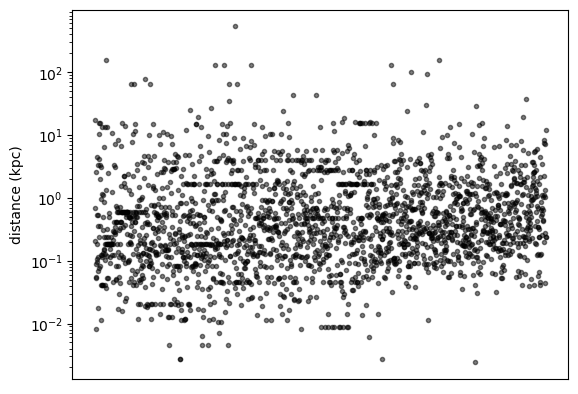

In [18]:
plt.plot(tbl.loc[tbl['distance']!='--']['distance']/1000,'k.',alpha=0.5)
plt.xticks([])
plt.ylabel('distance (kpc)')
plt.semilogy();

Right ascension and declination are given in J2000 decimal degrees.

Offsets are in arcseconds.

The `_n_match` parameters report he number of sources in the correspondin catalog that were within 12.5 arcseconds of the GALEX source position.